In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import re 
import numpy as np
import matplotlib
%matplotlib inline
#matplotlib 显示中文
matplotlib.rcParams['font.sans-serif']=['STHeiti']
from plotnine import *

In [2]:
#重要指标：评分、票房
#指标的分布（评分+票房的直方、核密度估计）
#1.哪些类型的电影表现好
    #整体情况
#2.不同年份电影整体表现的变化如何？
    #整体情况
#3.不同地区的电影的表现是否有差异
    #整体情况

#类型x年份:不同类型的电影表现的变化，有没有趋势？
#地区x年份:不同地区的电影表现的变化，有没有趋势？
#类型x地区:不同地区不同类型电影表现如何？
#地区x类型x年份：每个地区而言，不同类型的电影的表现有什么变化，不同地区得到的结论是否不同


#4.电影评分与票房之间是否存在相关性？
#5.电影的时长与评分、票房之间的关系如何？


In [3]:
data =  pd.read_excel('./movie.xlsx')
data.columns = ['电影名称', '类型', '主演', '链接', '评分', '票房', '上映时间', '地区', '时长']
# 显示数据的前几行，以确保数据被正确导入
data.head()

,电影名称,类型,主演,链接,评分,票房,上映时间,地区,时长
0,哪吒之魔童降世,动画／喜剧／奇幻,吕艳婷／囧森瑟夫／瀚墨,https://www.maoyan.com/films/1211270,9.6,50.36亿,2019-07-26,中国大陆,110.0
1,绿皮书,剧情／喜剧／传记,维果·莫腾森／马赫沙拉·阿里／琳达·卡德里尼,https://www.maoyan.com/films/1206605,9.5,4.79亿,2019-03-01,美国,130.0
2,绝杀慕尼黑,剧情／运动,弗拉基米尔·马什科夫／约翰·萨维奇／伊万·科列斯尼科夫,https://www.maoyan.com/films/1204589,9.5,9181万,2019-06-13,俄罗斯,121.0
3,海蒂和爷爷,剧情／家庭／冒险,阿努克·斯特芬／布鲁诺·甘茨／昆林·艾格匹,https://www.maoyan.com/films/337625,9.5,2093万,2019-05-16,瑞士，德国,111.0
4,古田军号,剧情／历史／战争,王仁君／王志飞／刘智扬,https://www.maoyan.com/films/1242130,9.5,5844万,2019-08-01,中国大陆,120.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1070 entries, 0 to 1069
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   电影名称    1070 non-null   object        
 1   类型      1069 non-null   object        
 2   主演      1047 non-null   object        
 3   链接      1070 non-null   object        
 4   评分      670 non-null    float64       
 5   票房      900 non-null    object        
 6   上映时间    1070 non-null   datetime64[ns]
 7   地区      1070 non-null   object        
 8   时长      1056 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 75.4+ KB


In [5]:
#将票房转换为数值，单位统一为万
data['票房'] = data['票房'].astype(str)
def convert_box_office(value):
    if '亿' in value:
        return float(re.sub(r'亿', '', value)) * 1e4
    elif '万' in value:
        return float(re.sub(r'万', '', value)) 
    else:
        return float(value)/10000

# 应用转换函数
data['票房（万）'] = data['票房'].apply(convert_box_office)

# 删除原始票房列
data.drop(columns=['票房'], inplace=True)


In [6]:
# 查看数据的描述性统计
data.describe()

,评分,上映时间,时长,票房（万）
count,670.000000,1070,1056.000000,9.000000e+02
mean,8.128358,2020-10-04 14:15:55.514018560,106.877083,7.078746e+04
min,3.700000,2019-01-04 00:00:00,3.000000,1.000000e+00
25%,7.600000,2019-10-22 00:00:00,90.000000,1.070000e+02
50%,8.400000,2020-11-13 00:00:00,99.000000,8.125000e+02
75%,8.900000,2021-08-14 00:00:00,112.000000,6.640500e+03
max,9.700000,2022-06-16 00:00:00,5146.000000,4.848000e+07
std,1.066378,NaN,159.760763,1.616607e+06


In [7]:
# 查看数据中的空值情况
data.isnull().sum()

电影名称       0
类型         1
主演        23
链接         0
评分       400
上映时间       0
地区         0
时长        14
票房（万）    170
dtype: int64

In [8]:
# 处理缺失值
#1.使用众数填充类型
most_common_type = data['类型'].mode()[0]
data['类型'] = data['类型'].fillna(most_common_type)

#2.删去评分和票房缺失的行
data = data.dropna(subset=['评分','票房（万）'])
#3.主演缺失的填充为“未知”
data['主演'] = data['主演'].fillna('未知')


#4.时长缺失的填充为平均值
data['时长'] = data['时长'].fillna(data['时长'].mean())

# 去除异常值
data = data[data['时长'] >= 60]


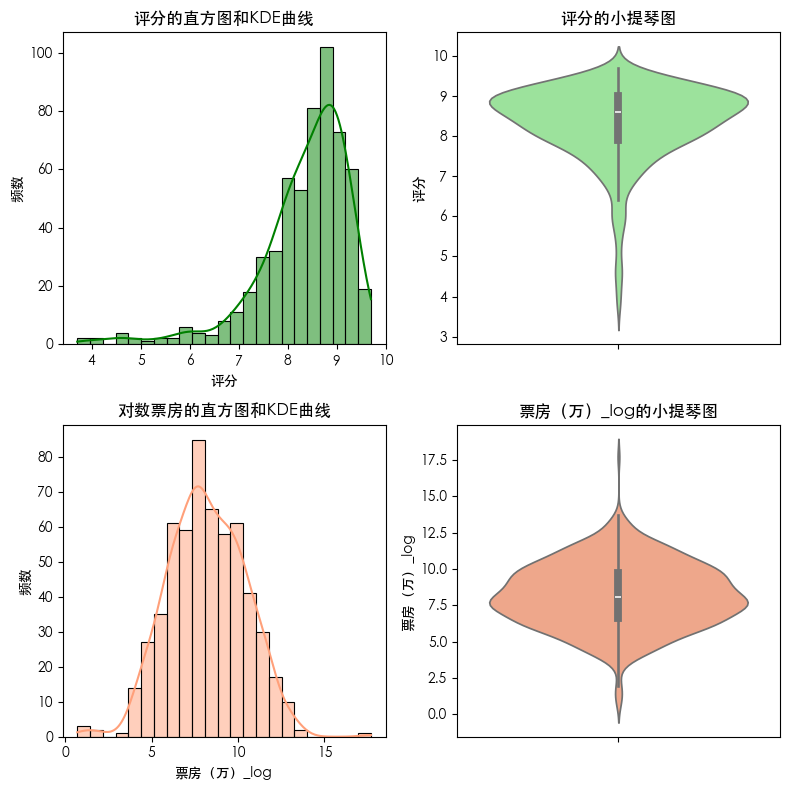

In [9]:
#探索性可视化，查看数据分布
#1.查看评分和票房分布
# 创建子图
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# 绘制评分的直方图和 KDE 曲线
sns.histplot(data['评分'], kde=True, color='green', ax=ax[0, 0])
ax[0, 0].set_title('评分的直方图和KDE曲线')
ax[0, 0].set_xlabel('评分')
ax[0, 0].set_ylabel('频数')

# 绘制评分的小提琴图
sns.violinplot(y=data['评分'], color="lightgreen", ax=ax[0, 1])
ax[0, 1].set_title('评分的小提琴图')
ax[0, 1].set_ylabel('评分')

# 对票房数据进行对数变换
data['票房（万）_log'] = np.log(data['票房（万）'])

# 绘制对数票房的直方图和 KDE 曲线
sns.histplot(data['票房（万）_log'], kde=True, color='lightsalmon', ax=ax[1, 0])
ax[1, 0].set_title('对数票房的直方图和KDE曲线')
ax[1, 0].set_xlabel('票房（万）_log')
ax[1, 0].set_ylabel('频数')

# 绘制对数票房的小提琴图
sns.violinplot(y=data['票房（万）_log'], color="lightsalmon", ax=ax[1, 1])
ax[1, 1].set_title('票房（万）_log的小提琴图')
ax[1, 1].set_ylabel('票房（万）_log')

# 调整子图布局
plt.tight_layout()
# 显示图形
plt.show()


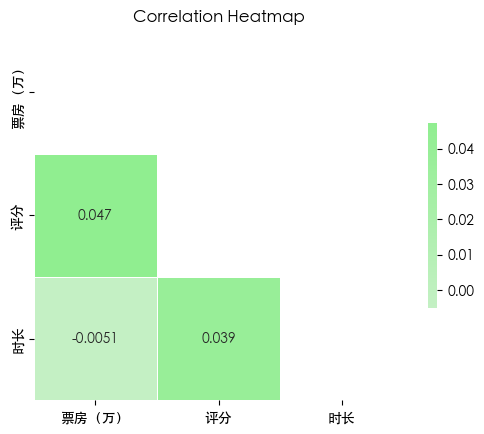

In [10]:
#票房、评分、时长、是否有相关性
from sklearn.preprocessing import StandardScaler

data_interst = data[['票房（万）','评分','时长']]
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_interst)

# 转换为 DataFrame
data_interst_scaled = pd.DataFrame(data_scaled, columns=data_interst.columns)

# 计算相关性矩阵
corr_matrix = data_interst_scaled.corr()
# 创建掩码以隐藏对角线
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, cmap=sns.light_palette("lightgreen", as_cmap=True), center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5},annot = True)

plt.title('Correlation Heatmap')
plt.show()

     类型   数量
0    剧情  260
1    喜剧  154
2    动画  126
3    冒险  123
4    动作  116
5    爱情  109
6    奇幻   69
7    犯罪   66
8    悬疑   63
9    家庭   47
10   科幻   42
11   战争   29
12  纪录片   26
13   惊悚   25
14   青春   24
15   历史   23
16   传记   18
17   灾难   16
18   音乐   12
19   恐怖   11
20   运动    8
21   儿童    5
22   歌舞    4
23   古装    3
24   武侠    1
25   戏曲    1


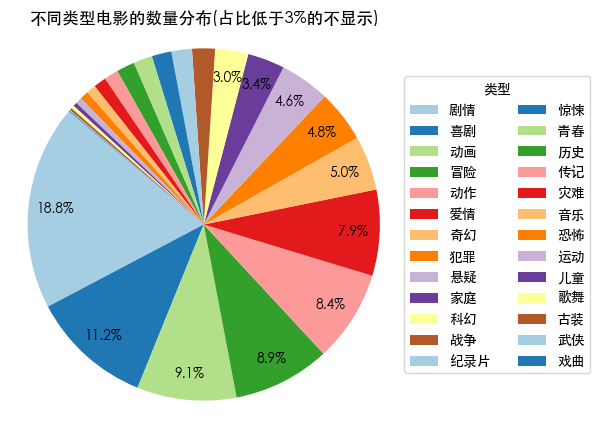

In [11]:
#问题1:不同类型电影的表现(评分+票房)如何？
#将类型拆分
type_split = data['类型'].str.split('／', expand=True).stack().reset_index(level=1, drop=True)
type_split.name = '类型'
type_counts = type_split.value_counts().reset_index()
type_counts.columns = ['类型', '数量']

print(type_counts)
# 计算总数量
total = type_counts['数量'].sum()

# 自定义标签函数(低于百分之三的不显示)
def autopct_func(pct):
    return ('%1.1f%%' % pct) if pct >= 3 else ''

# 绘制饼图
plt.figure(figsize=(5,5))
wedges, texts, autotexts = plt.pie(type_counts['数量'], labels=None, autopct=autopct_func, startangle=140, colors=plt.cm.Paired.colors, pctdistance=0.85)

# 设置标签和百分比标签的位置
for text in texts:
    text.set_fontsize(10)
    text.set_horizontalalignment('center')
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')
    autotext.set_weight('bold')
# 绘制外部标签
legend = plt.legend(wedges, type_counts['类型'], title="类型", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), ncol=2)

plt.title('不同类型电影的数量分布(占比低于3%的不显示)')
plt.axis('equal')  # 确保饼图是圆形的

# 保存图形，确保图例完整显示
plt.show()

data_expanded_type = data.drop(columns=['类型']).join(type_split)


     类型        评分          票房（万）
11   恐怖  5.836364    1376.454545
13   惊悚  6.864000   10685.280000
17   武侠  7.100000     583.000000
16   歌舞  7.575000    4409.250000
12   悬疑  7.922222   20149.206349
19   爱情  8.048624   13469.275229
21   科幻  8.195238   43599.619048
7    古装  8.200000   20156.000000
20   犯罪  8.219697   23403.242424
8    喜剧  8.250649   33538.577922
18   灾难  8.281250   73156.250000
24   青春  8.283333   16940.083333
9    奇幻  8.326087   41235.130435
4    动作  8.333621   35869.603448
3    剧情  8.406154  213136.969231
2    冒险  8.465041   27601.479675
10   家庭  8.485106   13626.574468
1    儿童  8.580000    4788.000000
15   战争  8.679310   54347.793103
5    动画  8.682540  408138.079365
23   运动  8.812500    3795.750000
25   音乐  8.850000    4525.333333
0    传记  8.983333   28743.222222
22  纪录片  9.015385     992.615385
6    历史  9.043478   70239.478261
14   戏曲  9.100000    2334.000000


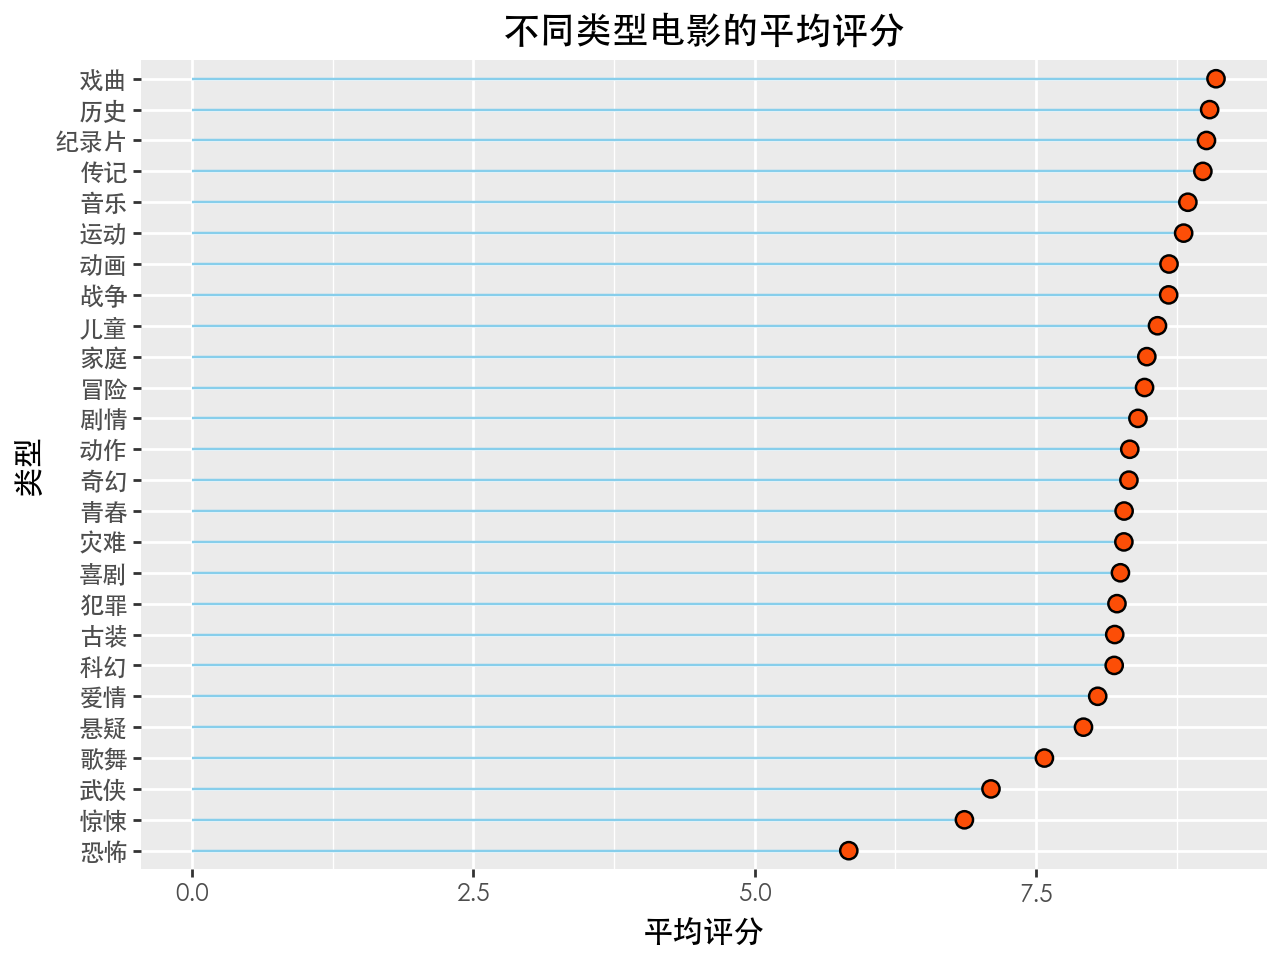

In [12]:
# 计算不同类型电影的平均评分和票房
average_data = data_expanded_type.groupby('类型').agg({'评分': 'mean', '票房（万）': 'mean'}).reset_index()
average_data_1 = average_data.sort_values(by='评分', ascending=True)
average_data_1['类型'] = pd.Categorical(average_data_1['类型'], categories=average_data_1['类型'], ordered=True) 
print(average_data_1)
# 绘制棒棒糖图
plot1 = (
    ggplot(average_data_1, aes(x='类型', y='评分')) +
    geom_segment(aes(x='类型', xend='类型', y=0, yend='评分'), color='skyblue') +
    geom_point(shape='o', size=3, color='k', fill='#FC4E07') +
    labs(title='不同类型电影的平均评分', x='类型', y='平均评分') +
    coord_flip()  +
    theme(text = element_text(family = "STHeiti"))  
    
)

plot1



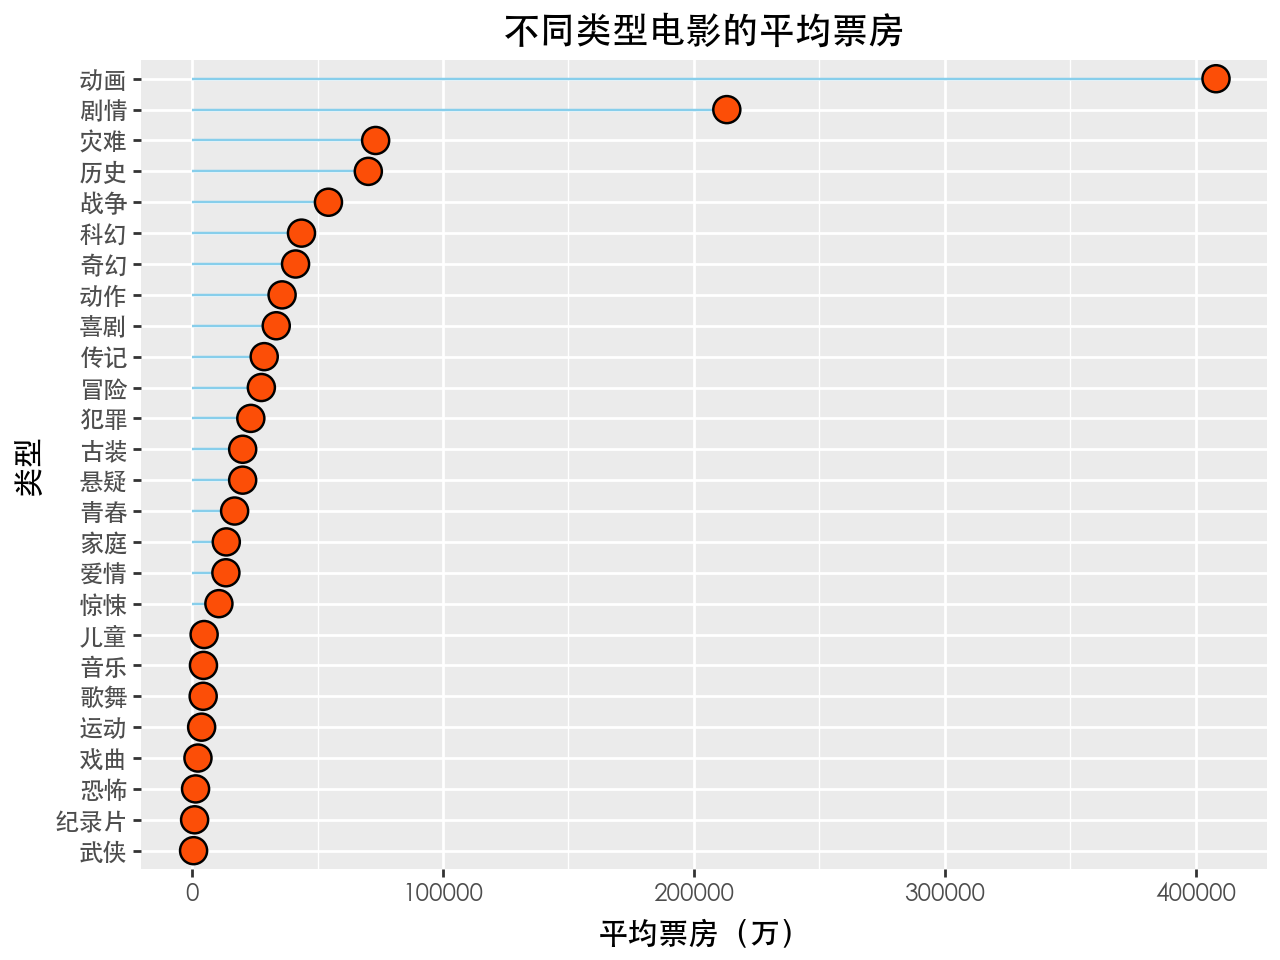

In [13]:
average_data_2 = average_data.sort_values(by='票房（万）', ascending=True)
average_data_2['类型'] = pd.Categorical(average_data_2['类型'], categories=average_data_2['类型'], ordered=True) 

plot2 = (
    ggplot(average_data_2, aes(x='类型', y='票房（万）')) +
    geom_segment(aes(x='类型', xend='类型', y=0, yend='票房（万）'), color='skyblue') +
    geom_point(shape='o', size=5, color='k', fill='#FC4E07') +
    labs(title='不同类型电影的平均票房', x='类型', y='平均票房（万）') +
    coord_flip()  +
    theme(text = element_text(family = "STHeiti"))
 
)
plot2

      地区   数量
0   中国大陆  331
1     美国  114
2     日本   43
3     英国   24
4     法国   18
5   中国香港   15
6     德国    9
7     印度    9
8    加拿大    8
9    俄罗斯    8
10   意大利    7
11  中国台湾    7
12   西班牙    3
13   比利时    3
14   爱尔兰    3
15   卢森堡    2
16    泰国    2
17    荷兰    2
18  澳大利亚    2
19    韩国    2
20   匈牙利    2
21   墨西哥    1
22   乌克兰    1
23   阿根廷    1
24   黎巴嫩    1
25    芬兰    1
26  马来西亚    1
27    越南    1
28    瑞士    1
29   土耳其    1
30  哥伦比亚    1
31  巴基斯坦    1
32  白俄罗斯    1
33    波兰    1


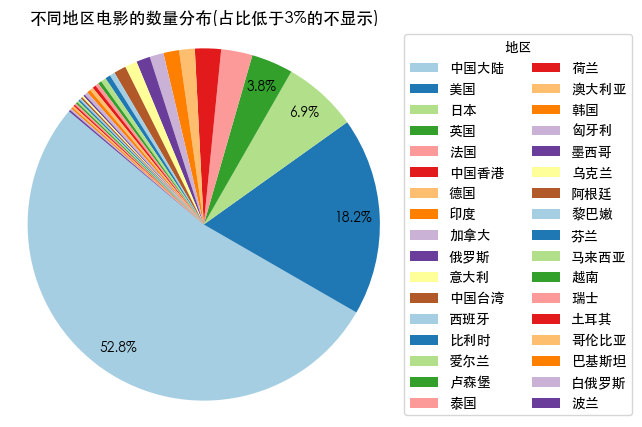

In [14]:
#不同地区电影的平均表现
#将地区拆分
region_split = data['地区'].str.split(r'[，,、……]', expand=True).stack().str.strip().reset_index(level=1, drop=True)
region_split.name = '地区'
region_split = region_split[region_split != '']
region_counts = region_split.value_counts().reset_index()
region_counts.columns = ['地区', '数量']
print(region_counts)
total = region_counts['数量'].sum()

# 自定义标签函数(低于百分之三的不显示)
def autopct_func(pct):
    return ('%1.1f%%' % pct) if pct >= 3 else ''

# 绘制饼图
plt.figure(figsize=(5,5))
wedges, texts, autotexts = plt.pie(region_counts['数量'], labels=None, autopct=autopct_func, startangle=140, colors=plt.cm.Paired.colors, pctdistance=0.85)

# 设置标签和百分比标签的位置
for text in texts:
    text.set_fontsize(10)
    text.set_horizontalalignment('center')
for autotext in autotexts:
    autotext.set_fontsize(10)
    autotext.set_color('black')
    autotext.set_weight('bold')

# 绘制外部标签
legend = plt.legend(wedges, region_counts['地区'], title="地区", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), ncol=2)

plt.title('不同地区电影的数量分布(占比低于3%的不显示)')
plt.axis('equal')  # 确保饼图是圆形的

plt.show()


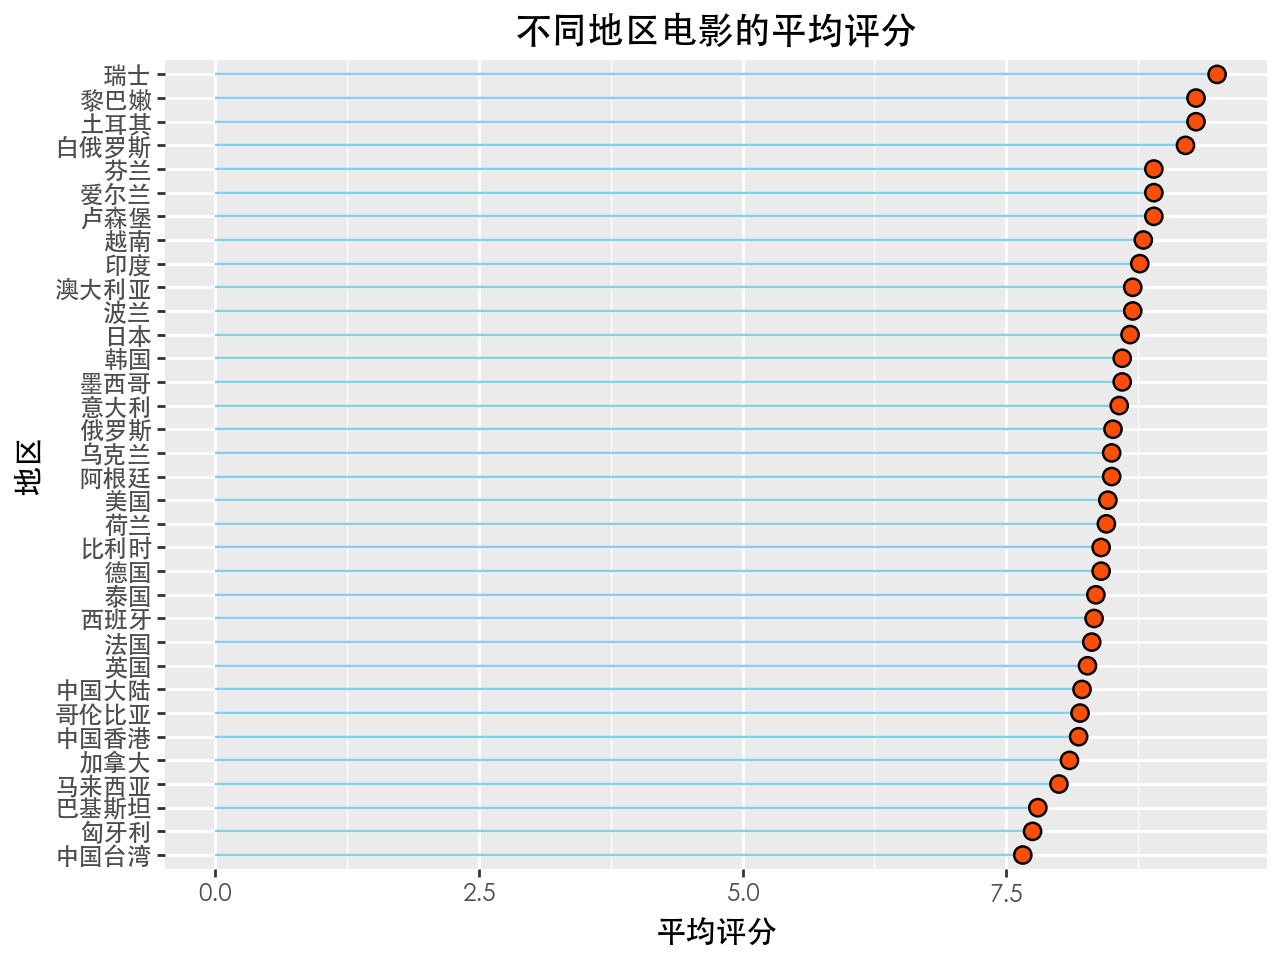

In [15]:
data_expanded_region = data.drop(columns=['地区']).join(region_split)
#评分
# 不同地区电影的平均评分和票房
average_data_region = data_expanded_region.groupby('地区').agg({'评分': 'mean', '票房（万）': 'mean'}).reset_index()
average_data_region_1 = average_data_region.sort_values(by='评分', ascending=True)
average_data_region_1['地区'] = pd.Categorical(average_data_region_1['地区'], categories=average_data_region_1['地区'], ordered=True) 

# 绘制棒棒糖图
plot1 = (
    ggplot(average_data_region_1, aes(x='地区', y='评分')) +
    geom_segment(aes(x='地区', xend='地区', y=0, yend='评分'), color='skyblue') +
    geom_point(shape='o', size=3, color='k', fill='#FC4E07') +
    labs(title='不同地区电影的平均评分', x='地区', y='平均评分') +
    coord_flip()  +
    theme(text = element_text(family = "STHeiti"))
    
)
plot1


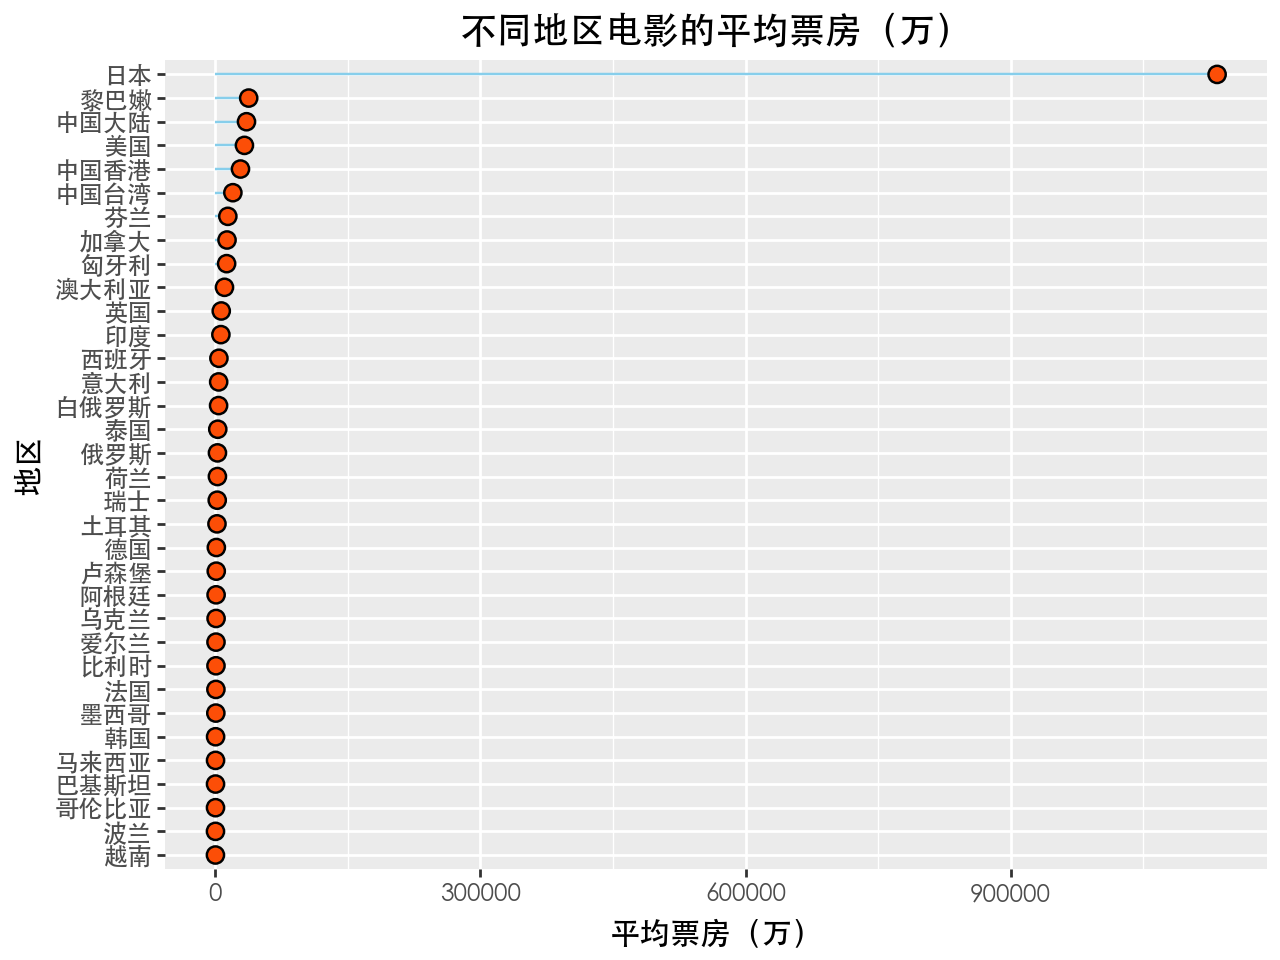

In [16]:
average_data_region_2 = average_data_region.sort_values(by='票房（万）', ascending=True)

average_data_region_2['地区'] = pd.Categorical(average_data_region_2['地区'], categories=average_data_region_2['地区'], ordered=True) 
plot2 = (
    ggplot(average_data_region_2, aes(x='地区', y='票房（万）')) +
    geom_segment(aes(x='地区', xend='地区', y=0, yend='票房（万）'), color='skyblue') +
    geom_point(shape='o', size=3, color='k', fill='#FC4E07') +
    labs(title='不同地区电影的平均票房（万）', x='地区', y='平均票房（万）') +
    coord_flip()  +
    theme(text = element_text(family = "STHeiti"))
    
)
plot2

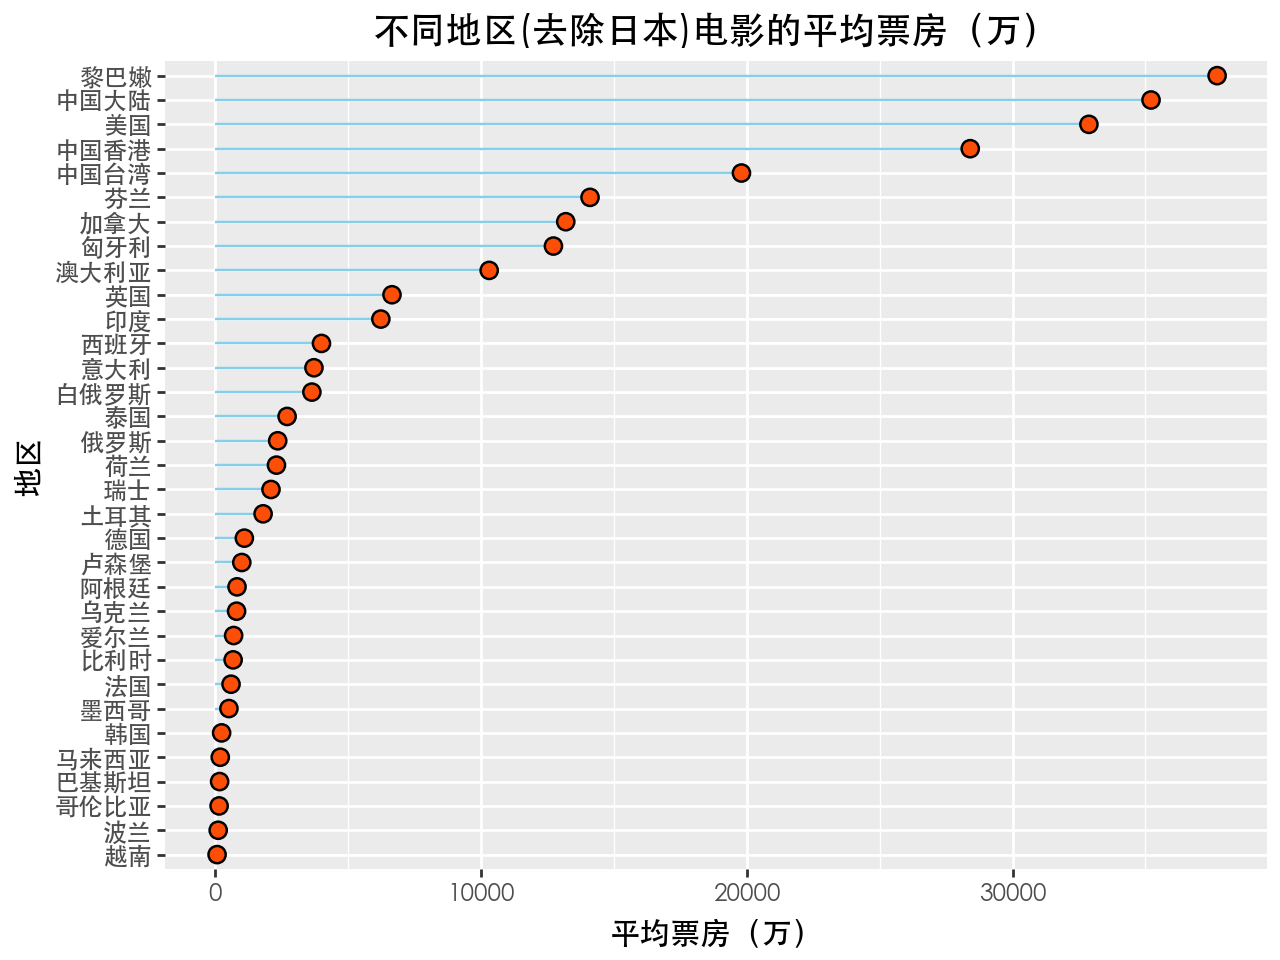

In [17]:
average_data_region_2_qv = average_data_region_2[average_data_region_2['地区'] != '日本'].reset_index()
plot2 = (
    ggplot(average_data_region_2_qv, aes(x='地区', y='票房（万）')) +
    geom_segment(aes(x='地区', xend='地区', y=0, yend='票房（万）'), color='skyblue') +
    geom_point(shape='o', size=3, color='k', fill='#FC4E07') +
    labs(title='不同地区(去除日本)电影的平均票房（万）', x='地区', y='平均票房（万）') +
    coord_flip()  +
    theme(text = element_text(family = "STHeiti"))
    
)

plot2

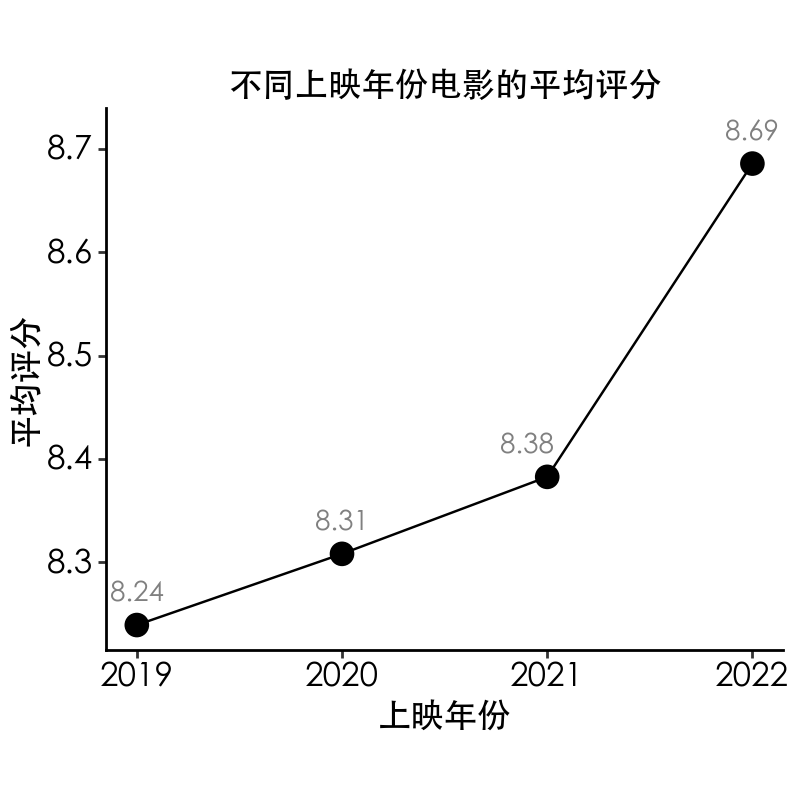

In [18]:
#不同年份电影的表现差异
data_expanded_region['上映年份'] = data_expanded_region['上映时间'].dt.year
# 不同年份电影的平均评分和票房
average_data_year = data_expanded_region.groupby('上映年份').agg({'评分': 'mean', '票房（万）': 'mean'}).reset_index()

# 绘制评分折线图

t = (
    ggplot(average_data_year,aes(x='上映年份', y='评分')) 
    + geom_line()
    + geom_point(size=4,color="black") 
    + labs(title='不同上映年份电影的平均评分', x='上映年份', y='平均评分') 
    + geom_text(aes(label=round(average_data_year['评分'],2)), nudge_x = [0,0,-0.1,0],nudge_y=0.03, size=10, color="grey")  # 添加点标签
    + theme_classic()

    + theme(text=element_text(size=12,colour = "black",family="STHeiti"),
        aspect_ratio=0.8,
        dpi=100,
        figure_size=(4,4),
        legend_position=(0.32,0.75),
        legend_background=element_rect(fill="none"))
  )

t

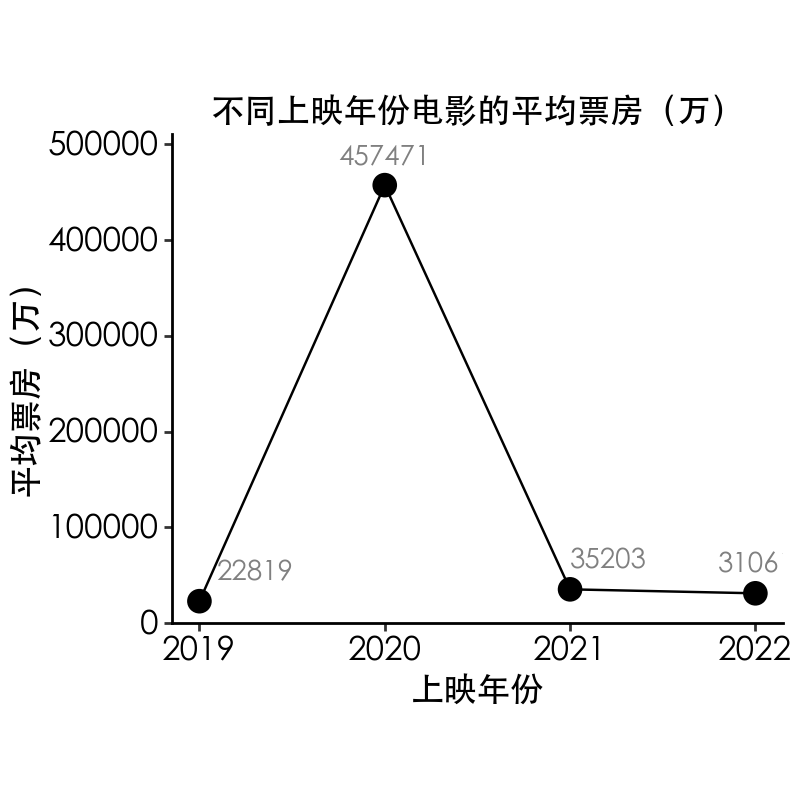

In [19]:
# 绘制票房折线图

t = (
    ggplot(average_data_year,aes(x='上映年份', y='票房（万）'))
    + geom_line()
    + geom_point(size=4,color="black") 
    + labs(title='不同上映年份电影的平均票房（万）', x='上映年份', y='平均票房（万）')
    + theme_classic()
    + geom_text(aes(label=np.round(average_data_year['票房（万）']).astype(int)),nudge_x = [0.3,0,0.2,0], nudge_y=30000, size=10, color="grey")  # 添加点标签
    + theme(text=element_text(size=12,colour = "black",family="STHeiti"),
        aspect_ratio=0.8,
        dpi=100,
        figure_size=(4,4),
        legend_position=(0.32,0.75),
        legend_background=element_rect(fill="none"))
        
)
t

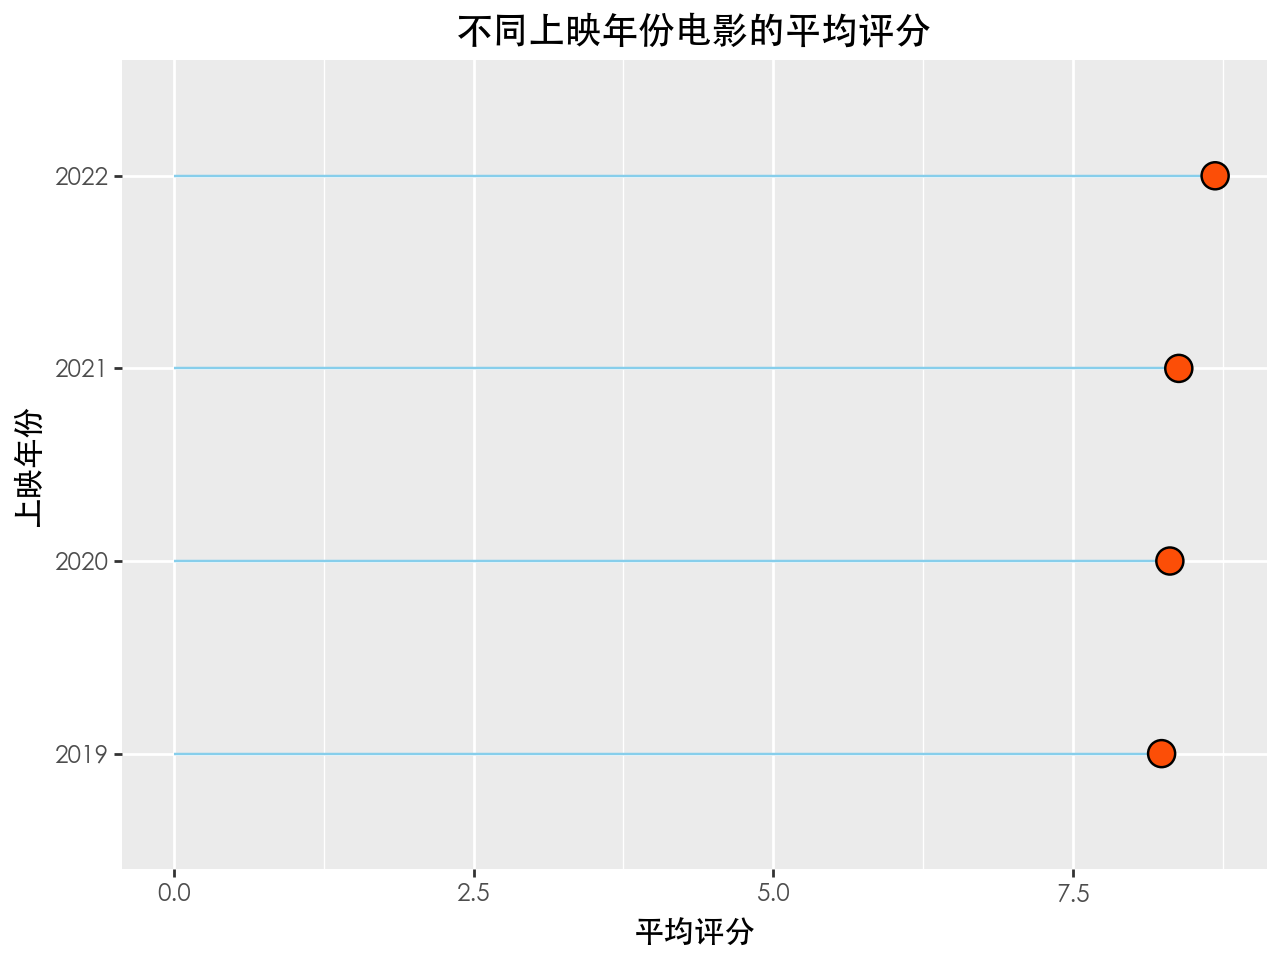

In [20]:
#不同年份电影的表现差异
data_expanded_region['上映年份'] = data_expanded_region['上映时间'].dt.year
# 不同年份电影的平均评分和票房
average_data_year = data_expanded_region.groupby('上映年份').agg({'评分': 'mean', '票房（万）': 'mean'}).reset_index()
average_data_year_1 = average_data_year.sort_values(by='评分', ascending=True)
average_data_year_1['上映年份'] = pd.Categorical(average_data_year_1['上映年份'], categories=average_data_year_1['上映年份'], ordered=True) 

# 绘制棒棒糖图
plot1 = (
    ggplot(average_data_year_1, aes(x='上映年份', y='评分')) +
    geom_segment(aes(x='上映年份', xend='上映年份', y=0, yend='评分'), color='skyblue') +
    geom_point(shape='o', size=5, color='k', fill='#FC4E07') +
    labs(title='不同上映年份电影的平均评分', x='上映年份', y='平均评分') +
    coord_flip()  +
    theme(text = element_text(family = "STHeiti"))
    
)

plot1

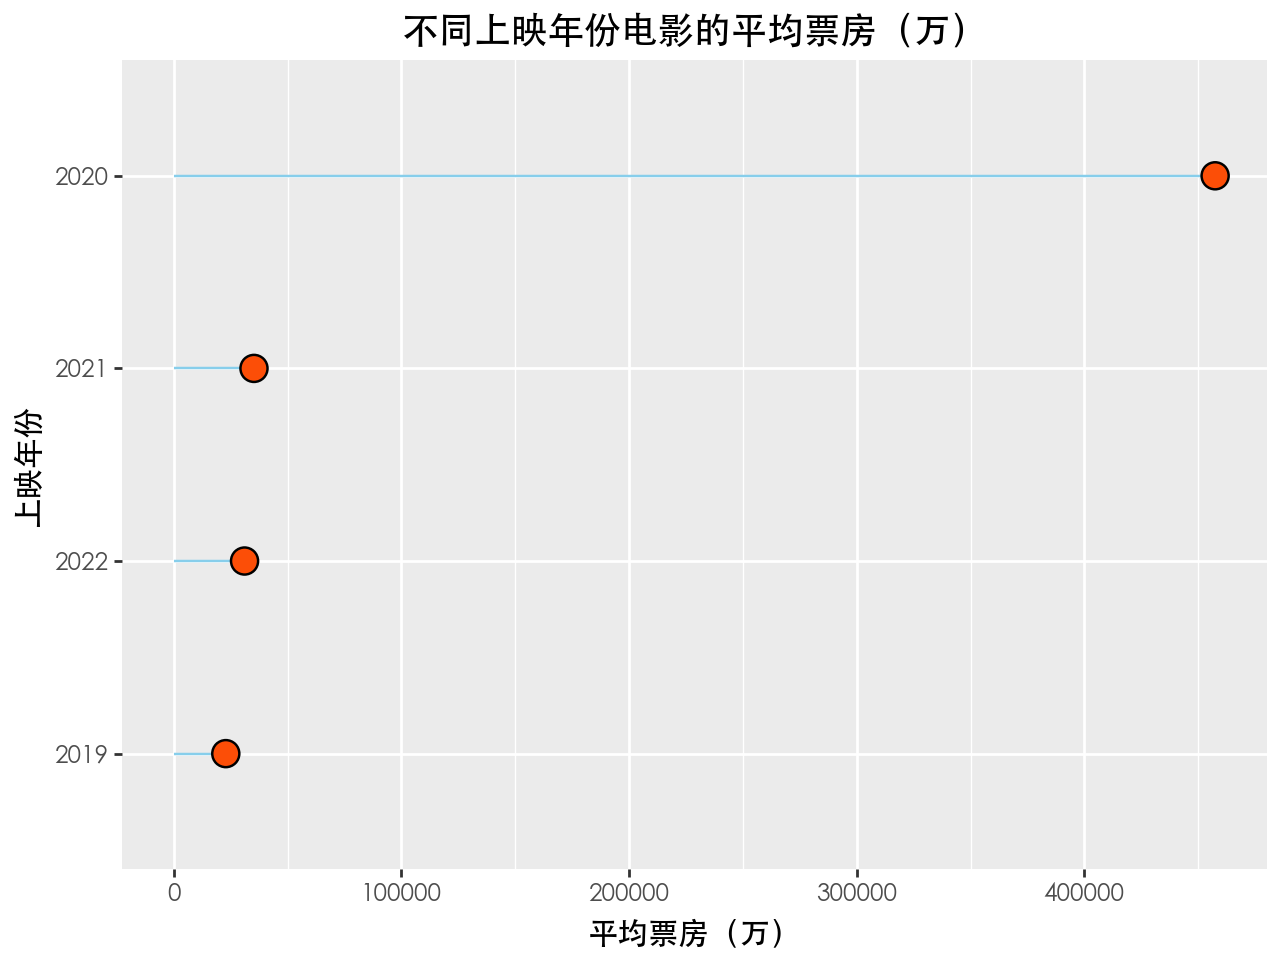

In [21]:
average_data_year_2 = average_data_year.sort_values(by='票房（万）', ascending=True)
average_data_year_2['上映年份'] = pd.Categorical(average_data_year_2['上映年份'], categories=average_data_year_2['上映年份'], ordered=True) 

# 绘制棒棒糖图
plot2 = (
    ggplot(average_data_year_2, aes(x='上映年份', y='票房（万）')) +
    geom_segment(aes(x='上映年份', xend='上映年份', y=0, yend='票房（万）'), color='skyblue') +
    geom_point(shape='o', size=5, color='k', fill='#FC4E07') +
    labs(title='不同上映年份电影的平均票房（万）', x='上映年份', y='平均票房（万）') +
    coord_flip()  +
    theme(text = element_text(family = "STHeiti"))
    
)

plot2

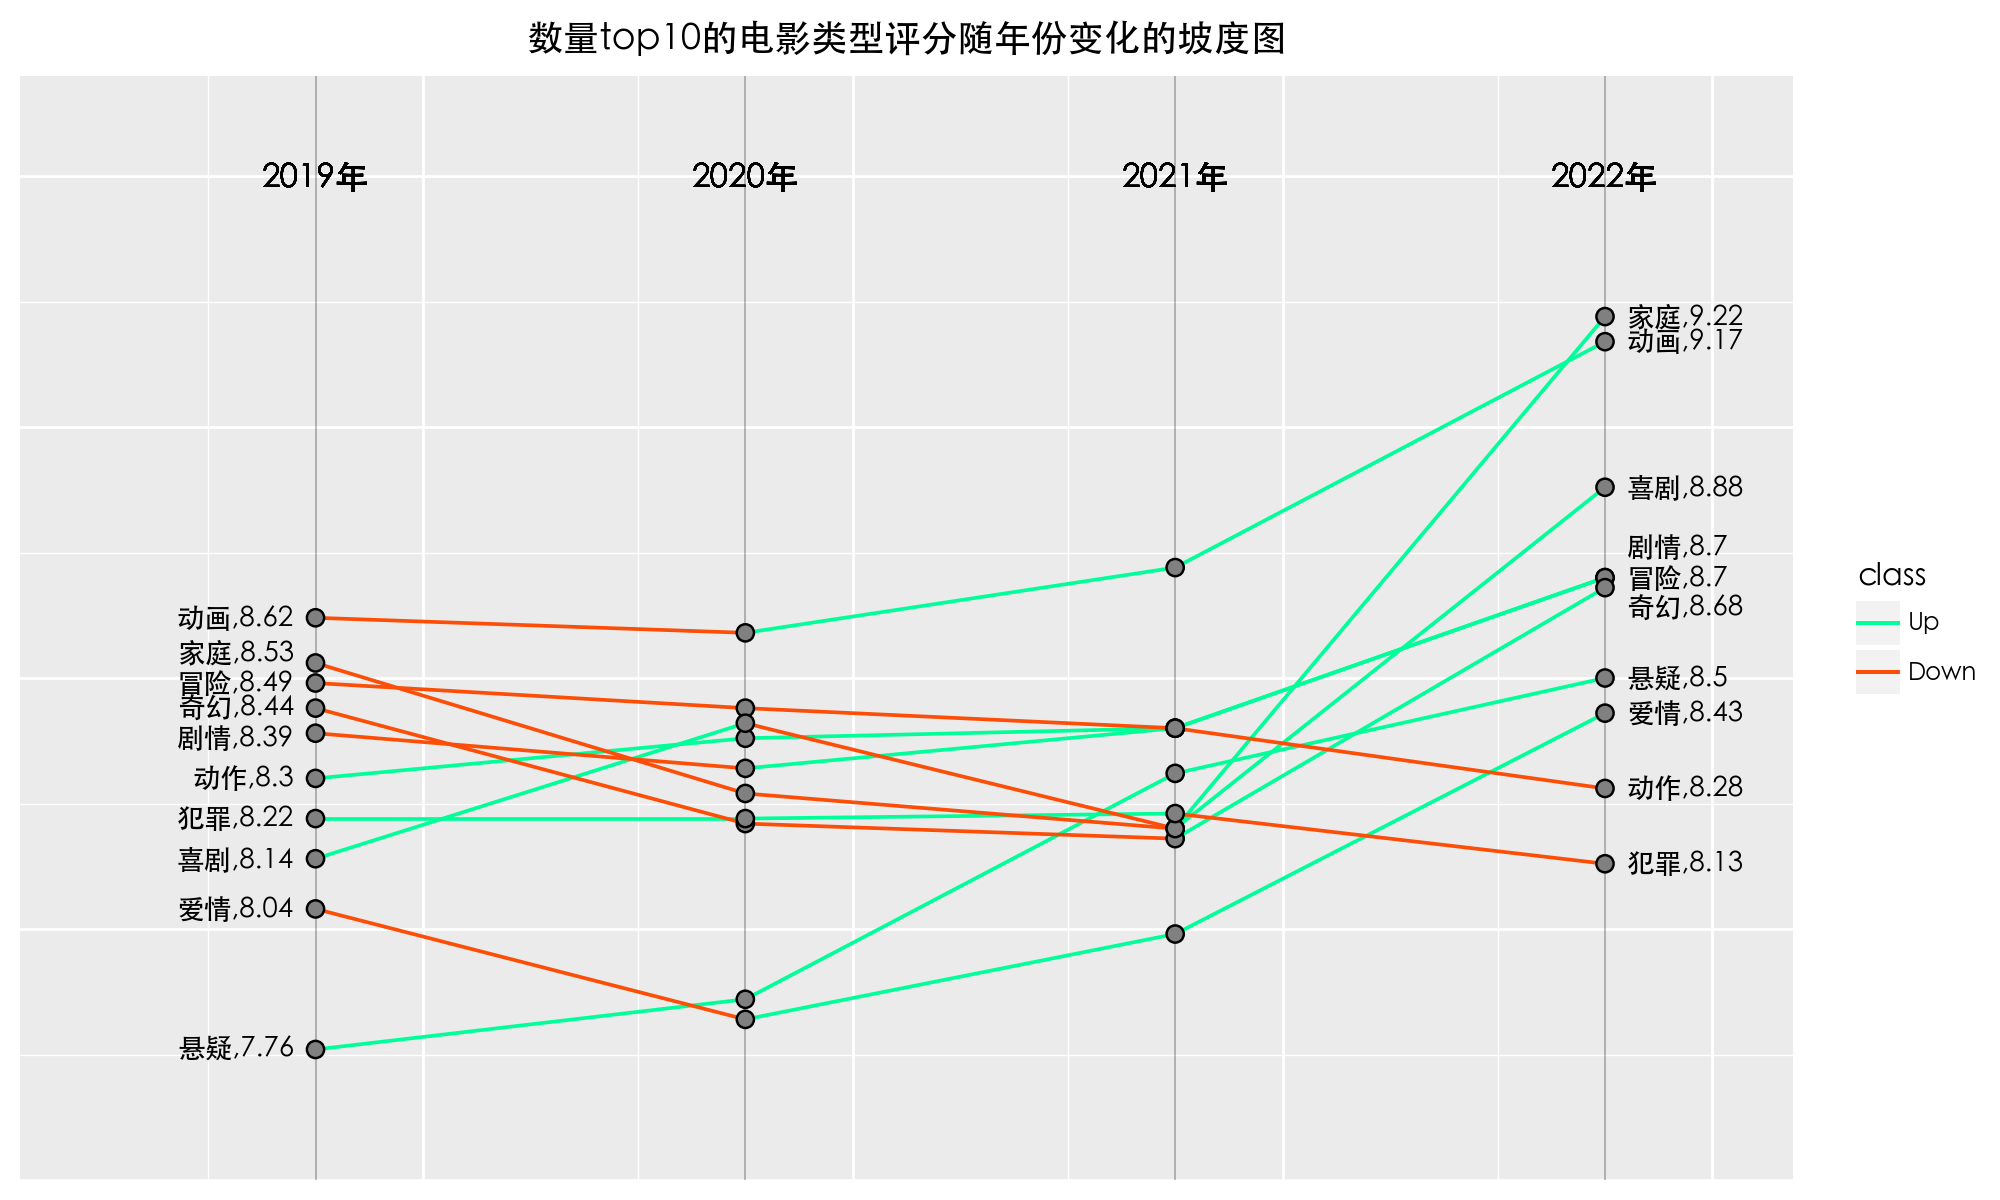

In [22]:
#类型x年份，选取数量前10的类型进一步分析不同年份的表现随时间的变化对比
#数量前10的类型评分的变化
data_expanded_type['上映年份'] = data_expanded_type['上映时间'].dt.year
top10_types = ['剧情','喜剧','动画','冒险','动作','爱情','奇幻','犯罪','悬疑','家庭']
selected_movies_1 = data_expanded_type[data_expanded_type['类型'].isin(top10_types)]
selected_movies_1 = selected_movies_1[['类型','上映年份','评分']].reset_index(drop=True)
selected_movies_avg_1 = selected_movies_1.groupby(['类型','上映年份']).agg({'评分': 'mean'}).reset_index()
selected_movies_avg_1['评分'] = round(selected_movies_avg_1['评分'],2)
# 转换数据格式以适合绘制坡度图
df = selected_movies_avg_1.pivot(index='类型', columns='上映年份', values='评分').reset_index()
df.columns = ['类型', '2019年', '2020年', '2021年', '2022年']
# 创建标签和颜色分类
left_label = df.apply(lambda x: x['类型'] + ',' + str(x['2019年']), axis=1)
right_label = df.apply(lambda x: x['类型'] + ',' + str(x['2022年']), axis=1)
df['class'] = df.apply(lambda x: 'red' if x['2020年'] - x['2019年'] < 0 else 'green', axis=1)
df['class2'] = df.apply(lambda x: 'red' if x['2021年'] - x['2020年'] < 0 else 'green', axis=1)
df['class3'] = df.apply(lambda x: 'red' if x['2022年'] - x['2021年'] < 0 else 'green', axis=1)

# 绘制坡度图
plot_time = (
    ggplot(df)
    + geom_segment(aes(x=1.5, xend=3.5, y='2019年', yend='2020年', color='class'), size=.75, show_legend=True)  # 2019-2020
    + geom_segment(aes(x=3.5, xend=5.5, y='2020年', yend='2021年', color='class2'), size=.75)  # 2020-2021
    + geom_segment(aes(x=5.5, xend=7.5, y='2021年', yend='2022年', color='class3'), size=.75)  # 2021-2022
    + geom_vline(xintercept=1.5, linetype='solid', size=.1)  # 2019年的垂直线
    + geom_vline(xintercept=3.5, linetype='solid', size=.1)  # 2020年的垂直线
    + geom_vline(xintercept=5.5, linetype='solid', size=.1)  # 2021年的垂直线
    + geom_vline(xintercept=7.5, linetype='solid', size=.1)  # 2022年的垂直线
    + geom_point(aes(x=1.5, y='2019年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=3.5, y='2020年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=5.5, y='2021年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=7.5, y='2022年'), size=3, shape='o', fill='grey', color='k')
    + scale_color_manual(labels=('Up', 'Down'), values=('#00FF99', '#FC4E07'))
    + xlim(.5, 8)
    + ylim(7.6, 9.6)
    + ggtitle("数量top10的电影类型评分随年份变化的坡度图")
    + geom_text(aes(x=1.4, y='2019年', label=left_label), size=10, ha='right', nudge_y=[0,-0.01,0,0,0,0,0.02,0,0,0 ])
    + geom_text(aes(x=7.6, y='2022年', label=right_label), size=10, ha='left', nudge_y=[0,0.06,0,0,0,-0.04,0,0,0,0 ])
    + geom_text(label='2019年', x=1.5, y=1.03 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']]))), size=12)
    + geom_text(label='2020年', x=3.5, y=1.03 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']]))), size=12)
    + geom_text(label='2021年', x=5.5, y=1.03 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']]))), size=12)
    + geom_text(label='2022年', x=7.5, y=1.03 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']]))), size=12)
    + theme(
        figure_size=(10, 6),
        text=element_text(family="STHeiti"),
        axis_title_x=element_blank(),  # 隐藏x轴标题
        axis_title_y=element_blank(),  # 隐藏y轴标题
        axis_text_x=element_blank(),   # 隐藏x轴刻度标签
        axis_text_y=element_blank(),   # 隐藏y轴刻度标签
        axis_ticks=element_blank()  # 隐藏x轴和y轴的刻度线
    )
    
)
# 显示图像
plot_time

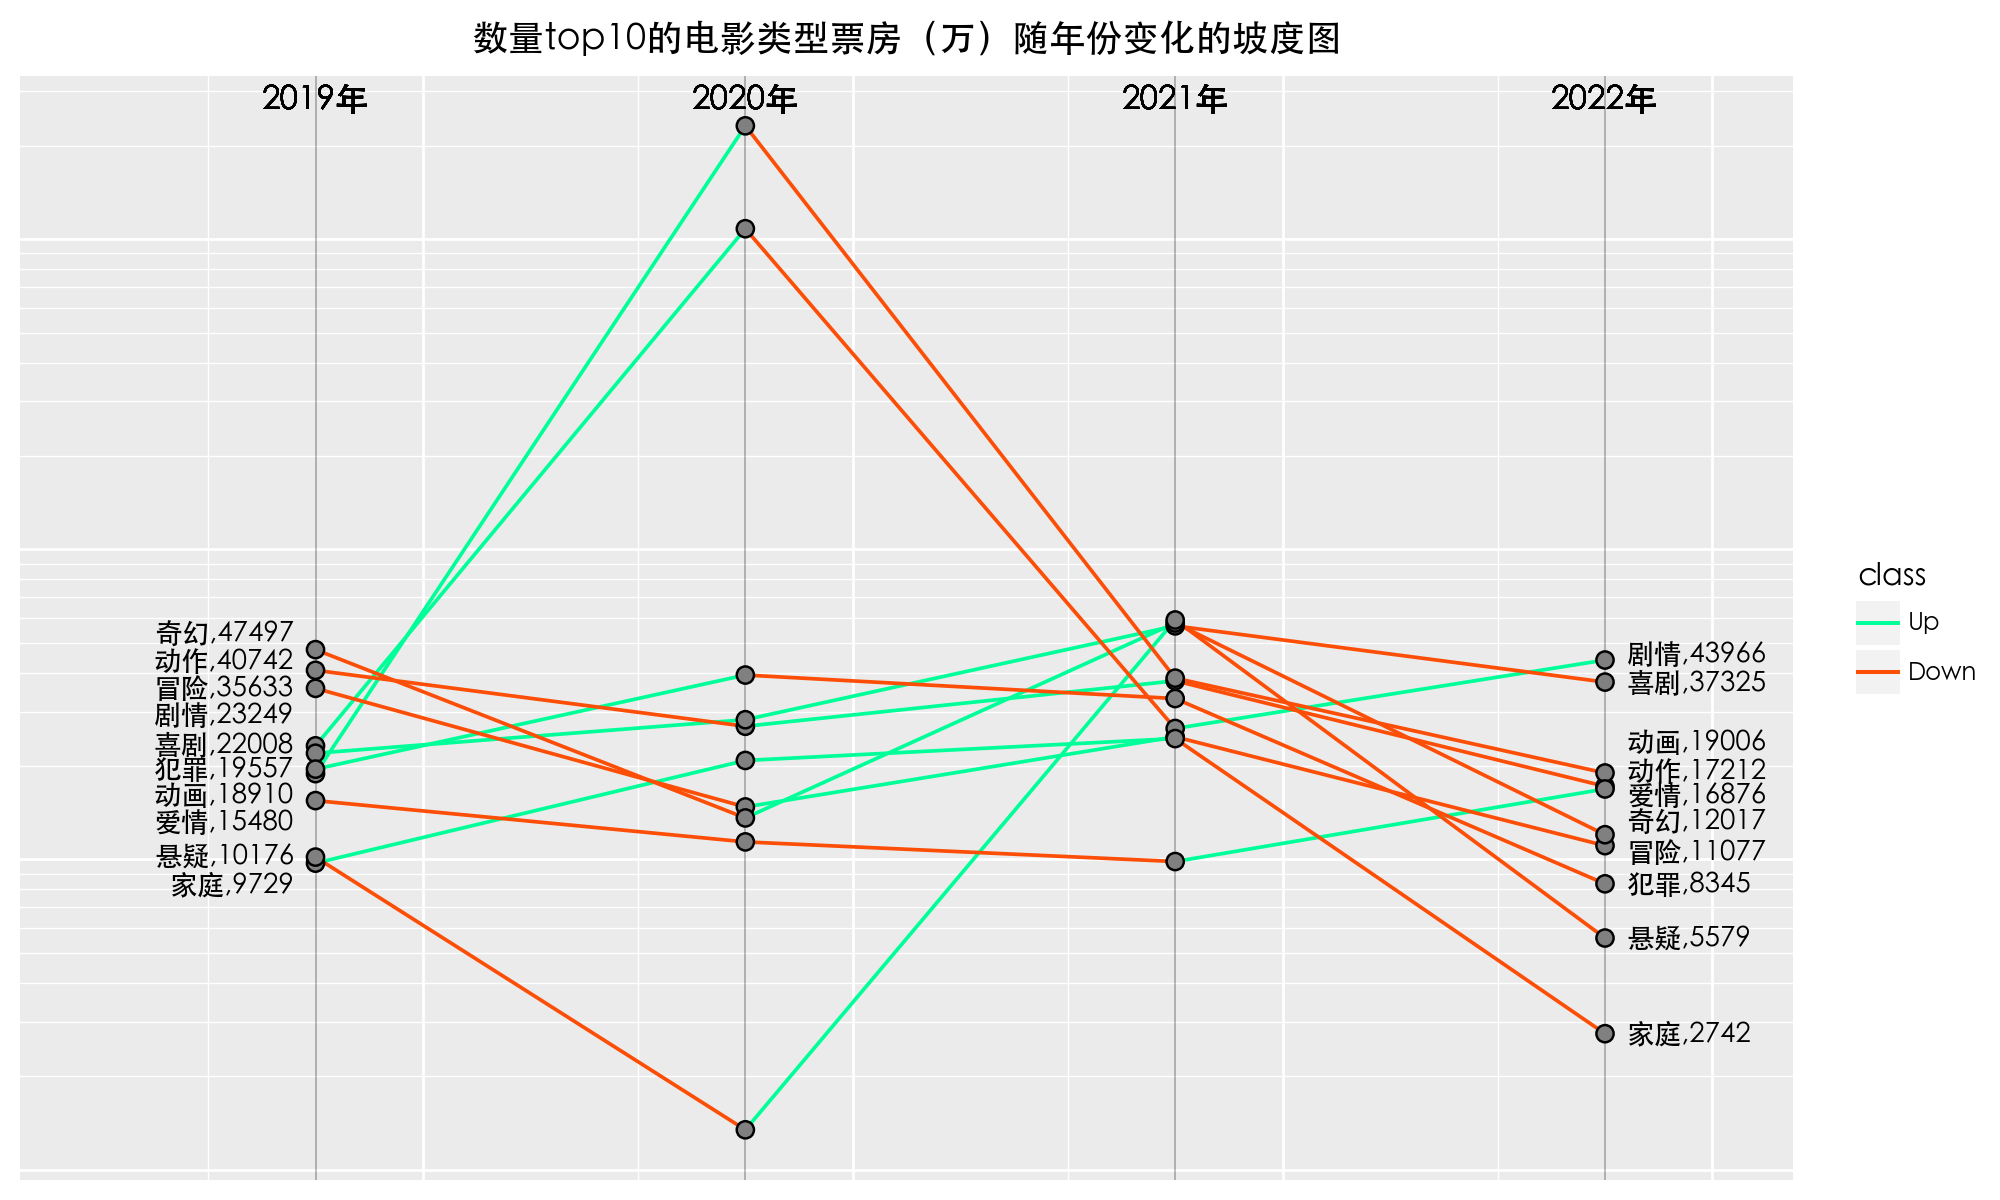

In [23]:
#类型x年份，选取数量前10的类型进一步分析不同年份的表现随时间的变化对比
#数量前10的类型票房的变化
selected_movies_2 = data_expanded_type[data_expanded_type['类型'].isin(top10_types)]
selected_movies_2 = selected_movies_2[['类型','上映年份','票房（万）']].reset_index(drop=True)
selected_movies_avg_2 = selected_movies_2.groupby(['类型','上映年份']).agg({'票房（万）': 'mean'}).reset_index()
selected_movies_avg_2['票房（万）'] = np.round(selected_movies_avg_2['票房（万）']).astype(int)
# 转换数据格式以适合绘制坡度图
df = selected_movies_avg_2.pivot(index='类型', columns='上映年份', values='票房（万）').reset_index()
df.columns = ['类型', '2019年', '2020年', '2021年', '2022年']

# 创建标签和颜色分类
left_label = df.apply(lambda x: x['类型'] + ',' + str(x['2019年']), axis=1)
right_label = df.apply(lambda x: x['类型'] + ',' + str(x['2022年']), axis=1)
df['class'] = df.apply(lambda x: 'red' if x['2020年'] - x['2019年'] < 0 else 'green', axis=1)
df['class2'] = df.apply(lambda x: 'red' if x['2021年'] - x['2020年'] < 0 else 'green', axis=1)
df['class3'] = df.apply(lambda x: 'red' if x['2022年'] - x['2021年'] < 0 else 'green', axis=1)
max_value = np.log(df[['2019年', '2020年', '2021年', '2022年']]).max().max()

# 绘制坡度图
plot_time = (
    ggplot(df)
    + geom_segment(aes(x=1.5, xend=3.5, y='2019年', yend='2020年', color='class'), size=.75, show_legend=True)  # 2019-2020
    + geom_segment(aes(x=3.5, xend=5.5, y='2020年', yend='2021年', color='class2'), size=.75)  # 2020-2021
    + geom_segment(aes(x=5.5, xend=7.5, y='2021年', yend='2022年', color='class3'), size=.75)  # 2021-2022
    + geom_vline(xintercept=1.5, linetype='solid', size=.1)  # 2019年的垂直线
    + geom_vline(xintercept=3.5, linetype='solid', size=.1)  # 2020年的垂直线
    + geom_vline(xintercept=5.5, linetype='solid', size=.1)  # 2021年的垂直线
    + geom_vline(xintercept=7.5, linetype='solid', size=.1)  # 2022年的垂直线
    + geom_point(aes(x=1.5, y='2019年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=3.5, y='2020年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=5.5, y='2021年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=7.5, y='2022年'), size=3, shape='o', fill='grey', color='k')
    + scale_color_manual(labels=('Up', 'Down'), values=('#00FF99', '#FC4E07'))
    + xlim(.5, 8)
    + scale_y_log10()  # 使用对数刻度
    + ggtitle("数量top10的电影类型票房（万）随年份变化的坡度图")
    + geom_text(aes(x=1.4, y='2019年', label=left_label), size=10, ha='right', nudge_y=[0,0.1,0.03,-0.07,0.03,0.05,-0.07,0,-0.07,0 ])
    + geom_text(aes(x=7.6, y='2022年', label=right_label), size=10, ha='left', nudge_y=[-0.02,0.02,0.05,0.1,0,0.04,0,0,-0.02,0 ])
    + geom_text(label='2019年', x=1.5, y=np.log10(1.21 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']])))), size=12)
    + geom_text(label='2020年', x=3.5, y=np.log10(1.21* (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']])))), size=12)
    + geom_text(label='2021年', x=5.5, y=np.log10(1.21 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']])))), size=12)
    + geom_text(label='2022年', x=7.5, y=np.log10(1.21 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']])))), size=12)
    + theme(
        figure_size=(10, 6),
        text=element_text(family="STHeiti"),
        axis_title_x=element_blank(),  # 隐藏x轴标题
        axis_title_y=element_blank(),  # 隐藏y轴标题
        axis_text_x=element_blank(),   # 隐藏x轴刻度标签
        axis_text_y=element_blank(),   # 隐藏y轴刻度标签
        axis_ticks=element_blank()  # 隐藏x轴和y轴的刻度线
    )
    
)
# 显示图像
plot_time

     地区  2019年  2020年  2021年  2022年
0  中国大陆   7.99   8.27   8.35   8.83
1  中国香港   6.20   8.76   8.34   8.20
2    日本   8.75   8.45   8.69   8.90
3    法国   8.43   7.97   8.13   8.60
4    美国   8.52   8.35   8.50   8.46
5    英国   8.36   7.83   8.53   8.37


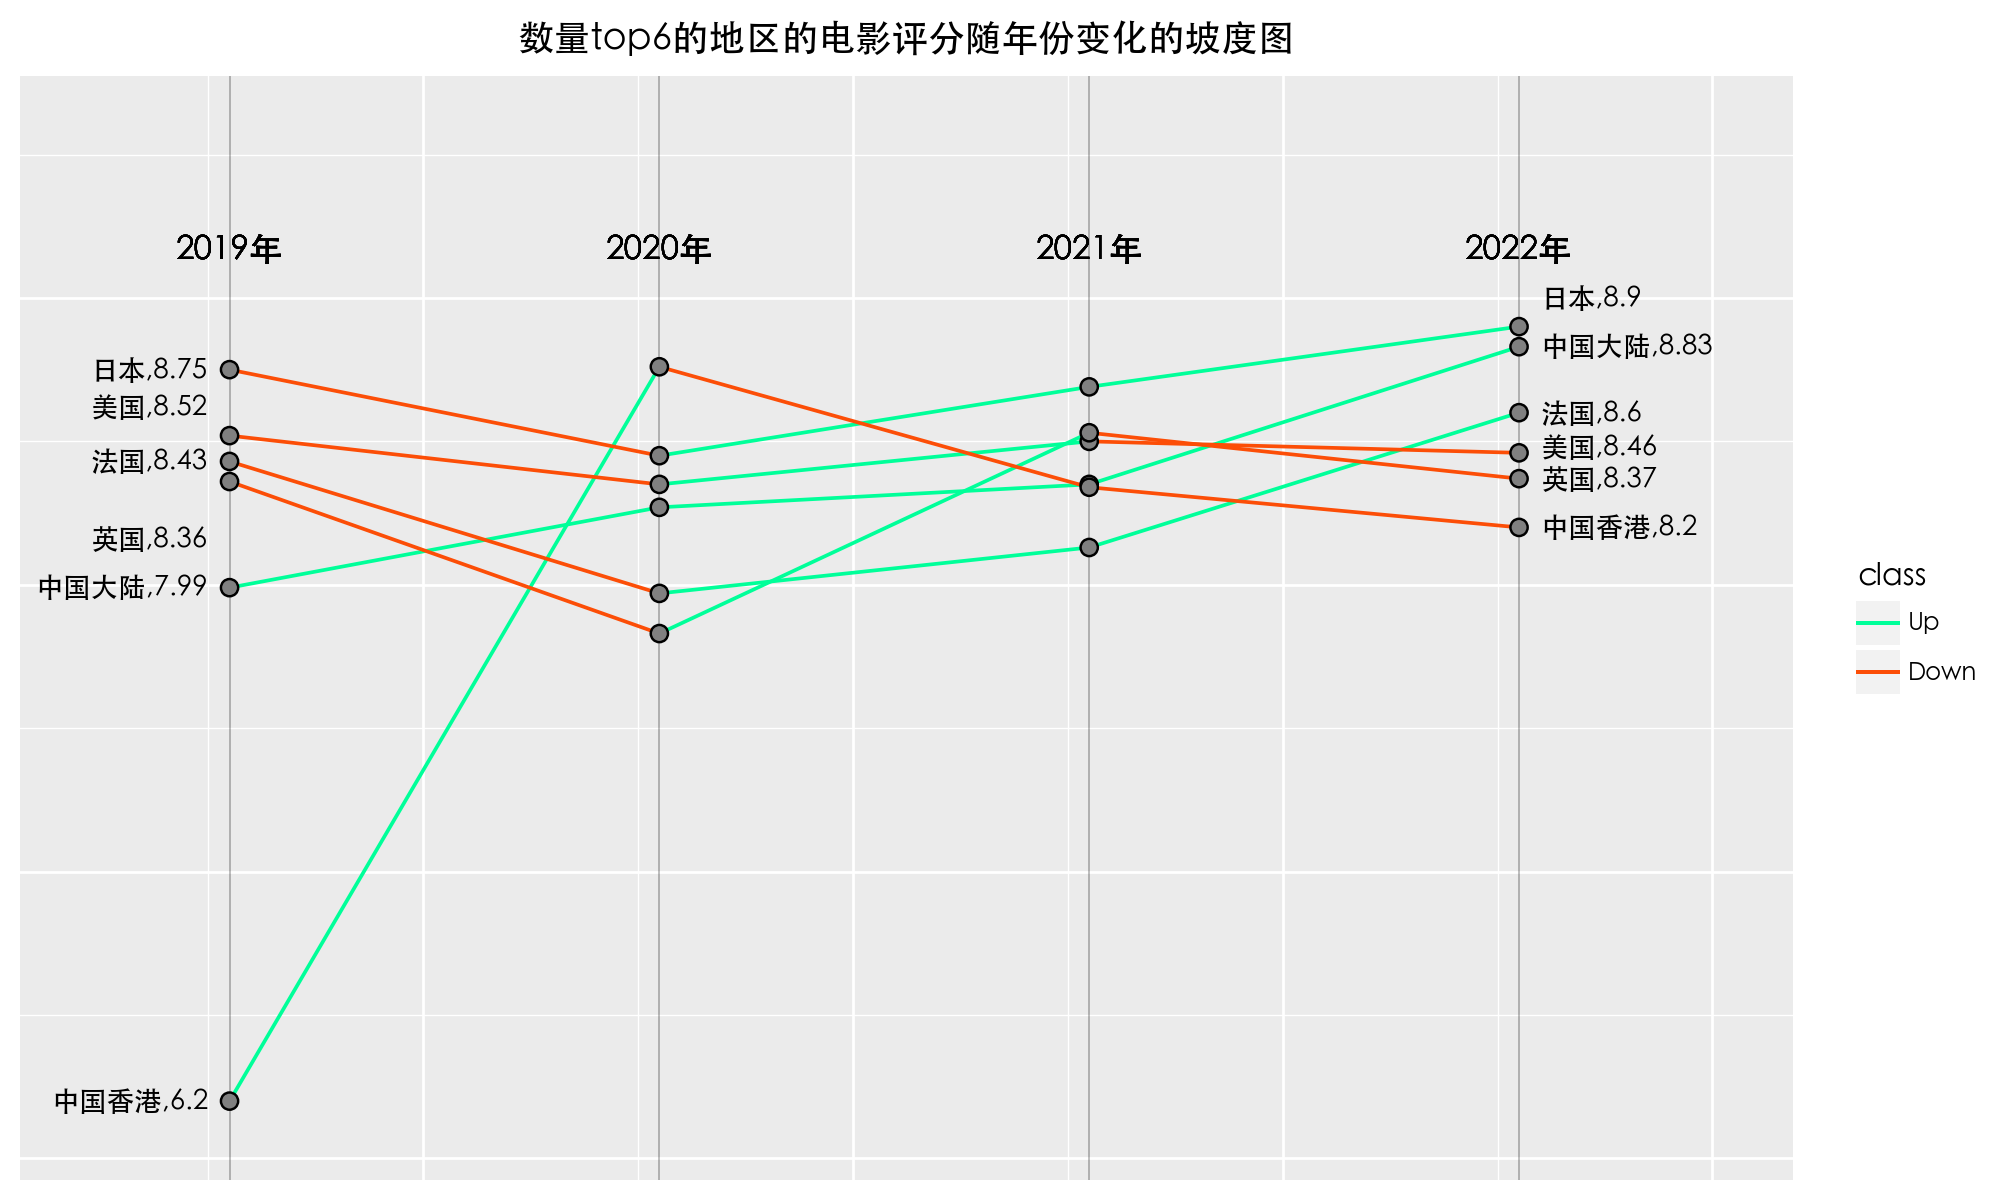

In [24]:
#地区x年份，选取数量前6的地区进一步分析不同年份的表现随时间的变化对比
#数量前6的地区的电影评分的变化
data_expanded_region['上映年份'] = data_expanded_region['上映时间'].dt.year
top6_regions = ['中国大陆','美国','日本','英国','法国','中国香港']
selected_movies_region_1 = data_expanded_region[data_expanded_region['地区'].isin(top6_regions)]
selected_movies_region_1 = selected_movies_region_1[['地区','上映年份','评分']].reset_index(drop=True)
selected_movies_region_avg_1 = selected_movies_region_1.groupby(['地区','上映年份']).agg({'评分': 'mean'}).reset_index()
selected_movies_region_avg_1['评分'] = round(selected_movies_region_avg_1['评分'],2)
# 转换数据格式以适合绘制坡度图
df = selected_movies_region_avg_1.pivot(index='地区', columns='上映年份', values='评分').reset_index()
df.columns = ['地区', '2019年', '2020年', '2021年', '2022年']
print(df)
# 创建标签和颜色分类
left_label = df.apply(lambda x: x['地区'] + ',' + str(x['2019年']), axis=1)
right_label = df.apply(lambda x: x['地区'] + ',' + str(x['2022年']), axis=1)
df['class'] = df.apply(lambda x: 'red' if x['2020年'] - x['2019年'] < 0 else 'green', axis=1)
df['class2'] = df.apply(lambda x: 'red' if x['2021年'] - x['2020年'] < 0 else 'green', axis=1)
df['class3'] = df.apply(lambda x: 'red' if x['2022年'] - x['2021年'] < 0 else 'green', axis=1)

# 绘制坡度图
plot_time = (
    ggplot(df)
    + geom_segment(aes(x=1.1, xend=3.1, y='2019年', yend='2020年', color='class'), size=.75, show_legend=True)  # 2019-2020
    + geom_segment(aes(x=3.1, xend=5.1, y='2020年', yend='2021年', color='class2'), size=.75)  # 2020-2021
    + geom_segment(aes(x=5.1, xend=7.1, y='2021年', yend='2022年', color='class3'), size=.75)  # 2021-2022
    + geom_vline(xintercept=1.1, linetype='solid', size=.1)  # 2019年的垂直线
    + geom_vline(xintercept=3.1, linetype='solid', size=.1)  # 2020年的垂直线
    + geom_vline(xintercept=5.1, linetype='solid', size=.1)  # 2021年的垂直线
    + geom_vline(xintercept=7.1, linetype='solid', size=.1)  # 2022年的垂直线
    + geom_point(aes(x=1.1, y='2019年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=3.1, y='2020年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=5.1, y='2021年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=7.1, y='2022年'), size=3, shape='o', fill='grey', color='k')
    + scale_color_manual(labels=('Up', 'Down'), values=('#00FF99', '#FC4E07'))
    + xlim(.5, 8)
    + ylim(6.1, 9.6)
    + ggtitle("数量top6的地区的电影评分随年份变化的坡度图")
    + geom_text(aes(x=1, y='2019年', label=left_label), size=10, ha='right',nudge_y = [0,0,0,0,0.1,-0.2])
    + geom_text(aes(x=7.2, y='2022年', label=right_label), size=10, ha='left',nudge_y = [0,0,0.1,0,0.02,0])
    + geom_text(label='2019年', x=1.1, y=1.03 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']]))), size=12)
    + geom_text(label='2020年', x=3.1, y=1.03 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']]))), size=12)
    + geom_text(label='2021年', x=5.1, y=1.03 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']]))), size=12)
    + geom_text(label='2022年', x=7.1, y=1.03 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']]))), size=12)
    + theme(
        figure_size=(10, 6),
        text=element_text(family="STHeiti"),
        axis_title_x=element_blank(),  # 隐藏x轴标题
        axis_title_y=element_blank(),  # 隐藏y轴标题
        axis_text_x=element_blank(),   # 隐藏x轴刻度标签
        axis_text_y=element_blank(),   # 隐藏y轴刻度标签
        axis_ticks=element_blank()  # 隐藏x轴和y轴的刻度线
    )
)

plot_time

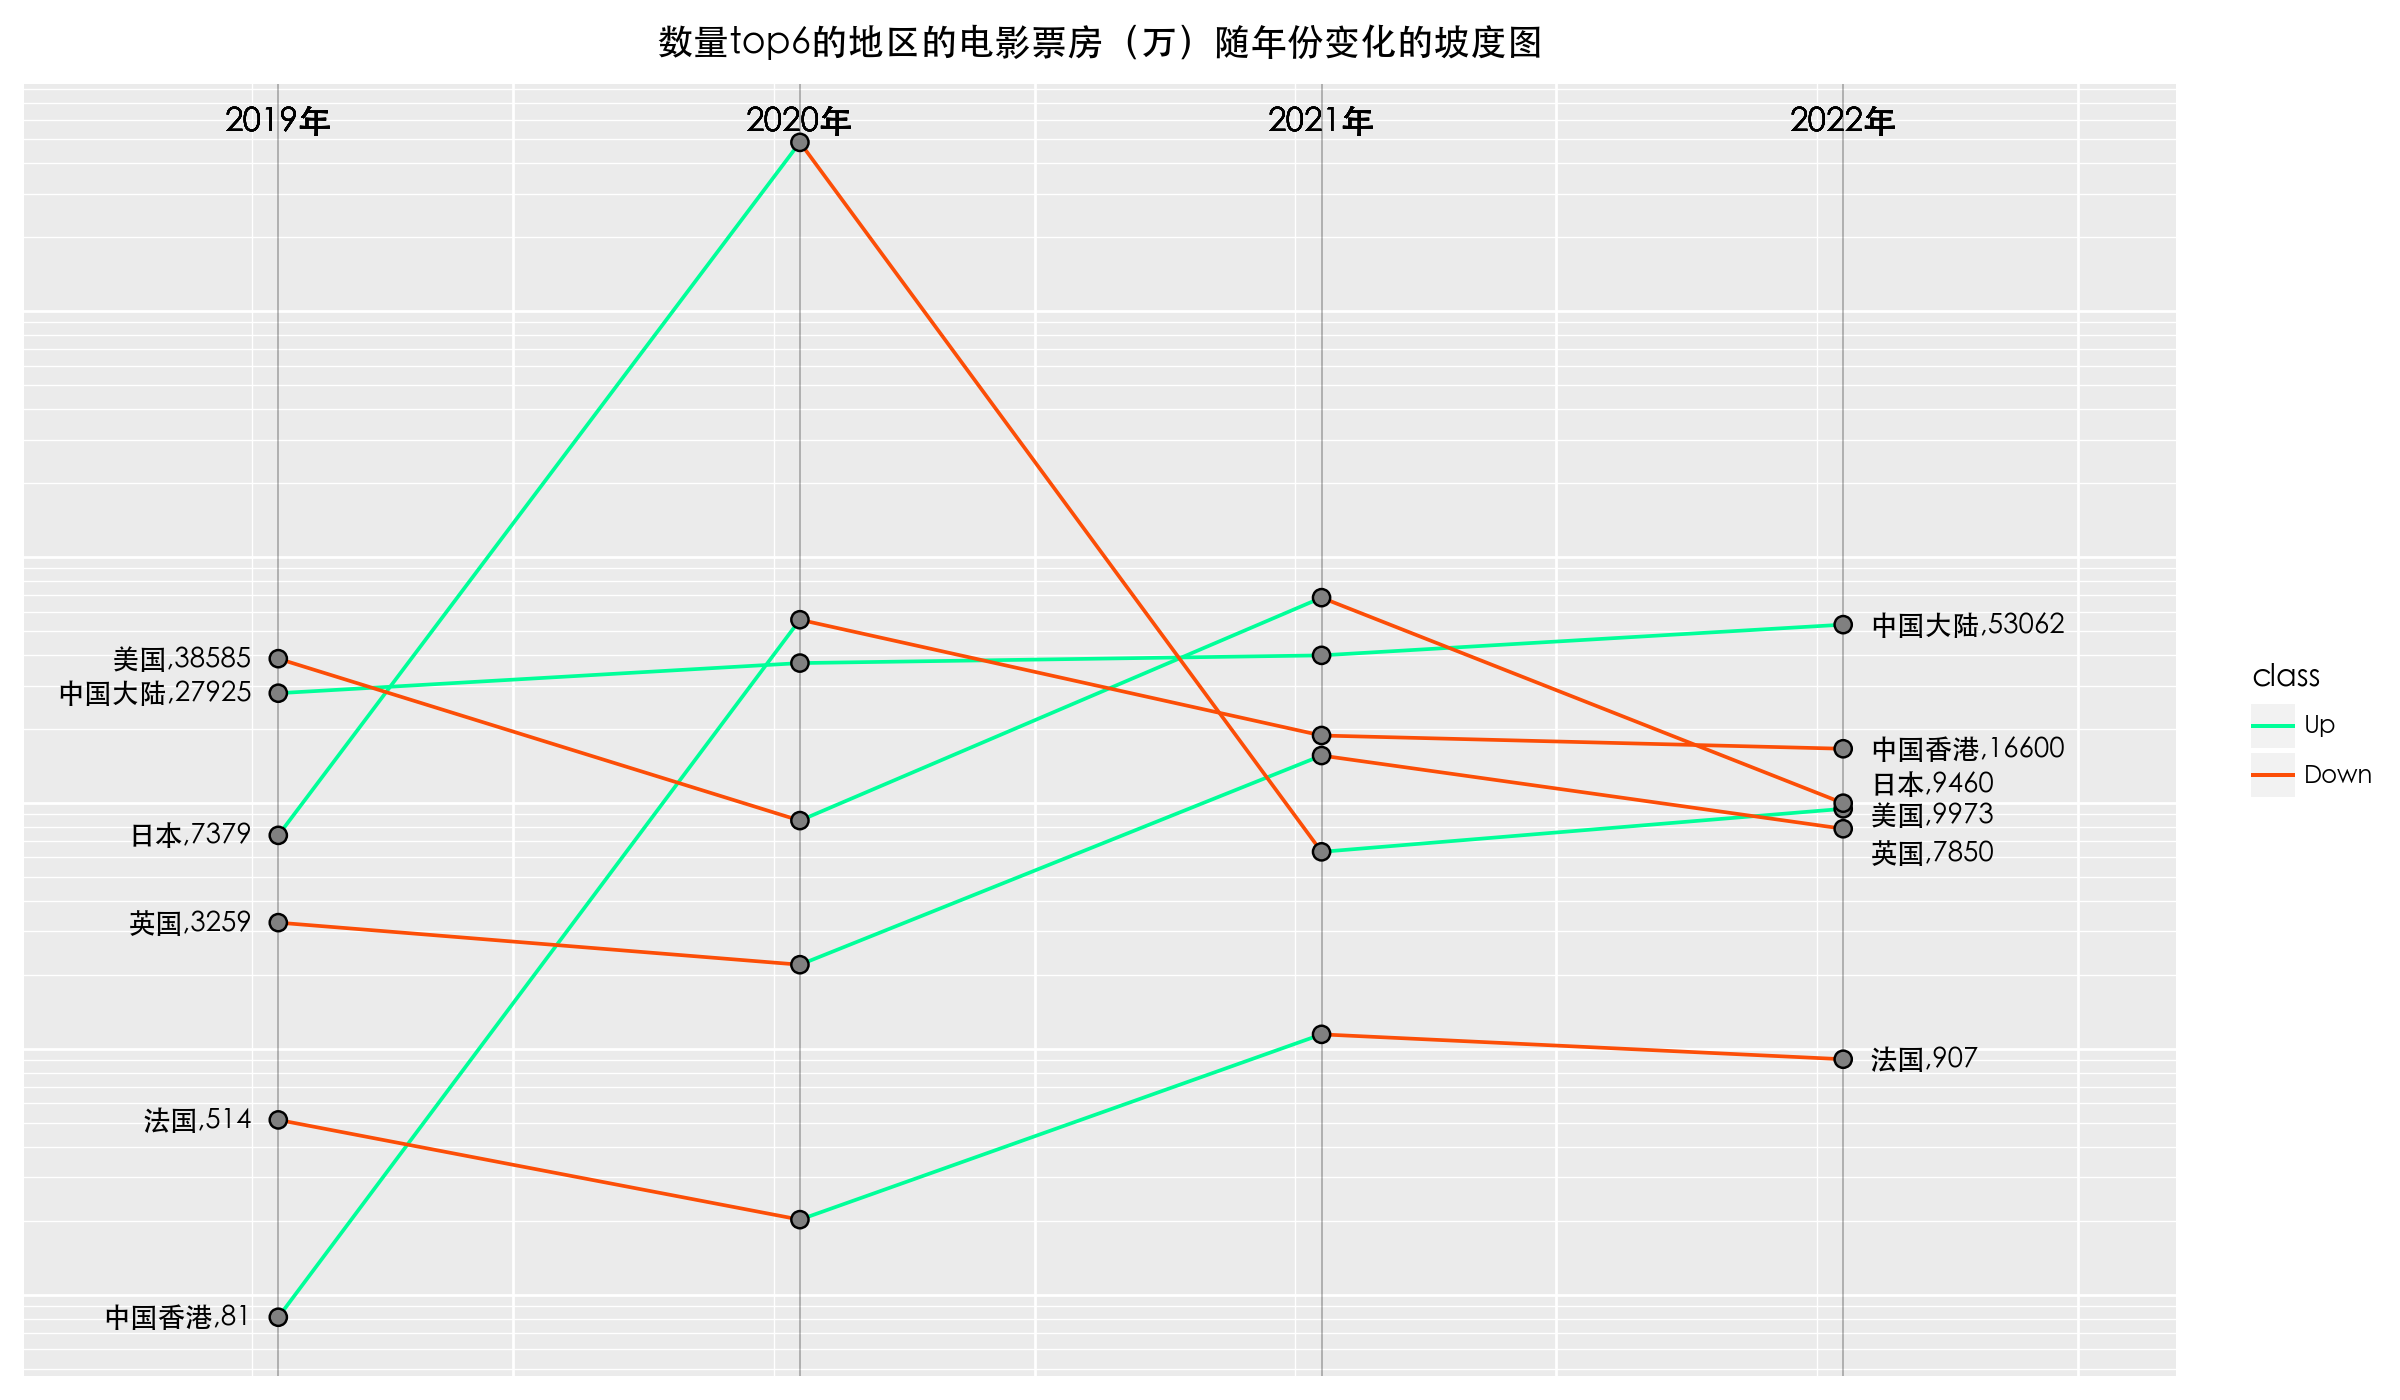

In [25]:
#数量前6的地区的电影票房的变化（取对数）
selected_movies_region_2 = data_expanded_region[data_expanded_region['地区'].isin(top6_regions)]
selected_movies_region_2 = selected_movies_region_2[['地区','上映年份','票房（万）']].reset_index(drop=True)
selected_movies_region_avg_2 = selected_movies_region_2.groupby(['地区','上映年份']).agg({'票房（万）': 'mean'}).reset_index()
selected_movies_region_avg_2['票房（万）'] = np.round(selected_movies_region_avg_2['票房（万）']).astype(int)
# 转换数据格式以适合绘制坡度图
df = selected_movies_region_avg_2.pivot(index='地区', columns='上映年份', values='票房（万）').reset_index()
df.columns = ['地区', '2019年', '2020年', '2021年', '2022年']

# 创建标签和颜色分类
left_label = df.apply(lambda x: x['地区'] + ',' + str(x['2019年']), axis=1)
right_label = df.apply(lambda x: x['地区'] + ',' + str(x['2022年']), axis=1)
df['class'] = df.apply(lambda x: 'red' if x['2020年'] - x['2019年'] < 0 else 'green', axis=1)
df['class2'] = df.apply(lambda x: 'red' if x['2021年'] - x['2020年'] < 0 else 'green', axis=1)
df['class3'] = df.apply(lambda x: 'red' if x['2022年'] - x['2021年'] < 0 else 'green', axis=1)

# 绘制坡度图
plot_time = (
    ggplot(df)
    + geom_segment(aes(x=1.1, xend=3.1, y='2019年', yend='2020年', color='class'), size=.75, show_legend=True)  # 2019-2020
    + geom_segment(aes(x=3.1, xend=5.1, y='2020年', yend='2021年', color='class2'), size=.75)  # 2020-2021
    + geom_segment(aes(x=5.1, xend=7.1, y='2021年', yend='2022年', color='class3'), size=.75)  # 2021-2022
    + geom_vline(xintercept=1.1, linetype='solid', size=.1)  # 2019年的垂直线
    + geom_vline(xintercept=3.1, linetype='solid', size=.1)  # 2020年的垂直线
    + geom_vline(xintercept=5.1, linetype='solid', size=.1)  # 2021年的垂直线
    + geom_vline(xintercept=7.1, linetype='solid', size=.1)  # 2022年的垂直线
    + geom_point(aes(x=1.1, y='2019年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=3.1, y='2020年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=5.1, y='2021年'), size=3, shape='o', fill='grey', color='k')
    + geom_point(aes(x=7.1, y='2022年'), size=3, shape='o', fill='grey', color='k')
    + scale_color_manual(labels=('Up', 'Down'), values=('#00FF99', '#FC4E07'))
    + xlim(.5, 8)
    + scale_y_log10()  # 使用对数刻度
    + ggtitle("数量top6的地区的电影票房（万）随年份变化的坡度图")
    + geom_text(aes(x=1, y='2019年', label=left_label), size=10, ha='right')
    + geom_text(aes(x=7.2, y='2022年', label=right_label), size=10, ha='left',nudge_y = [0,0,0.1,0,-0.05,-0.1])
    + geom_text(label='2019年', x=1.1, y=np.log10(1.21 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']])))), size=12)
    + geom_text(label='2020年', x=3.1, y=np.log10(1.21 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']])))), size=12)
    + geom_text(label='2021年', x=5.1, y=np.log10(1.21 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']])))), size=12)
    + geom_text(label='2022年', x=7.1, y=np.log10(1.21 * (np.max(np.max(df[['2019年', '2020年', '2021年', '2022年']])))), size=12)
    + theme(
        figure_size=(12, 7),
        text=element_text(family="STHeiti"),
        axis_title_x=element_blank(),  # 隐藏x轴标题
        axis_title_y=element_blank(),  # 隐藏y轴标题
        axis_text_x=element_blank(),   # 隐藏x轴刻度标签
        axis_text_y=element_blank(),   # 隐藏y轴刻度标签
        axis_ticks=element_blank()  # 隐藏x轴和y轴的刻度线
    )
    
)

# 显示图像
plot_time

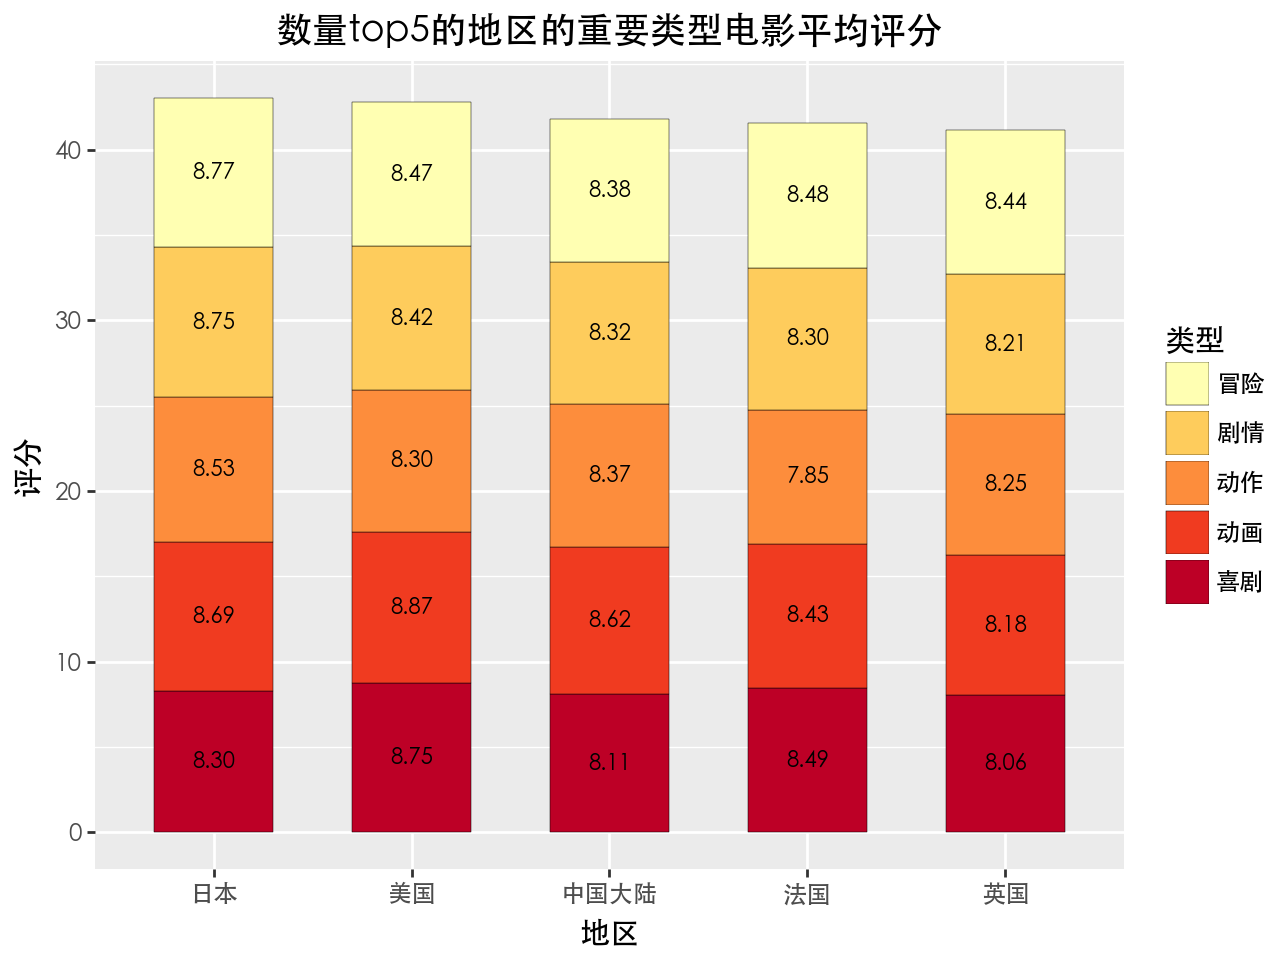

In [26]:
data_expanded_type_region = data.drop(columns=['地区','类型']).join([region_split,type_split])

#地区x类型 数量前5的地区前五个类型的平均评分
select_region = ['中国大陆','美国','日本','英国','法国']
select_type=['剧情','喜剧','动画','冒险','动作']
filtered_data = data_expanded_type_region[
    (data_expanded_type_region['地区'].isin(select_region)) &
    (data_expanded_type_region['类型'].isin(select_type))
]


# 计算每个地区和类型的平均评分
avg_scores = filtered_data.groupby(['地区','类型']).agg({'评分': 'mean'}).reset_index()
# 计算每个国家的评分总和
total_scores = avg_scores.groupby('地区')['评分'].sum().reset_index()

# 按评分总和排序
total_scores = total_scores.sort_values(by='评分', ascending=False)

# 将排序后的国家顺序应用到原始数据
sorted_data = avg_scores.set_index('地区').loc[total_scores['地区']].reset_index()
sorted_data['地区'] = pd.Categorical(sorted_data['地区'], categories=total_scores['地区'].unique(), ordered=True)


t = (
    ggplot(sorted_data, aes(x='地区', y='评分', fill='类型'))
    + geom_bar(stat='identity', color='k', position='stack', width=0.6, size=0.1)
    + scale_fill_brewer(palette='YlOrRd')
    + ggtitle("数量top5的地区的重要类型电影平均评分")
    + geom_text(aes(label=sorted_data['评分'].round(2)), position=position_stack(vjust=0.5), va='center', size=8, format_string='{:.2f}')
    + theme(text = element_text(family = "STHeiti"))
    

)
t

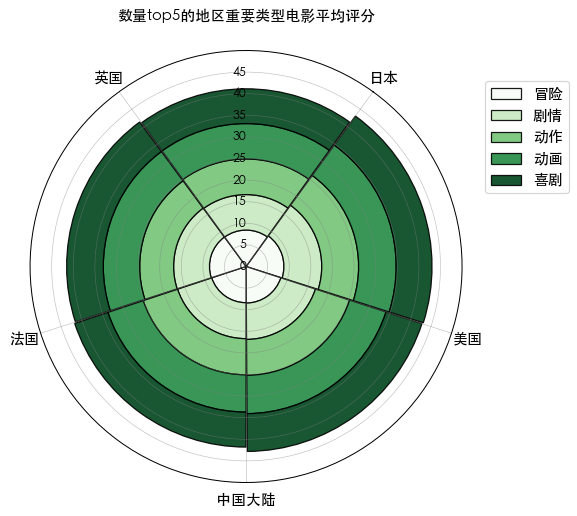

In [27]:
from matplotlib import colors
from matplotlib.pyplot import figure, show, rc

pivot_data_1 = sorted_data.pivot(index='地区', columns='类型', values='评分').reset_index()

n_row = pivot_data_1.shape[0]  # 地区数量
n_col = pivot_data_1.shape[1]-1# 类别数量

# 计算角度
angle = np.arange(0, 2*np.pi, 2*np.pi/n_row)

# 半径数组
radius = pivot_data_1.iloc[:, 1:6].values

cmap = plt.get_cmap('Greens', n_col) #获取颜色主题Reds的Hex颜色编码
color = [colors.rgb2hex(cmap(i)[:5]) for i in range(cmap.N)]
# 绘制堆叠条形图
fig = figure(figsize=(6,6), dpi=90)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
ax.set_theta_offset(np.pi/2 - np.pi/n_row)
ax.set_theta_direction(-1)
ax.set_rlabel_position(360-180/n_row)
p = [ f"p{i}" for i in range(n_col)]

bottom = radius[:, 0]*0
for i in range(n_col):
    p[i]= plt.bar(angle, radius[:, i], color=color[i], edgecolor='k', width=1.25, bottom=bottom, alpha=0.9, align = 'edge', label=pivot_data_1.columns[i + 1])
    bottom += radius[:, i]  # 更新底部
    
plt.legend(loc='center', bbox_to_anchor=(1.15, 0.3, 0, 1),fontsize=12)
plt.xticks(angle, labels=pivot_data_1['地区'],fontsize=12) #X轴标签
plt.ylim(0, 50)
plt.yticks(np.arange(0, 50, 5), verticalalignment='center', horizontalalignment='right')#horizontalalignment='right',右侧与90度垂直线对齐
plt.grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
plt.grid(which='major', axis='y', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
plt.title("数量top5的地区重要类型电影平均评分", x=0.5,y = 1.05,fontsize=12)
plt.show()



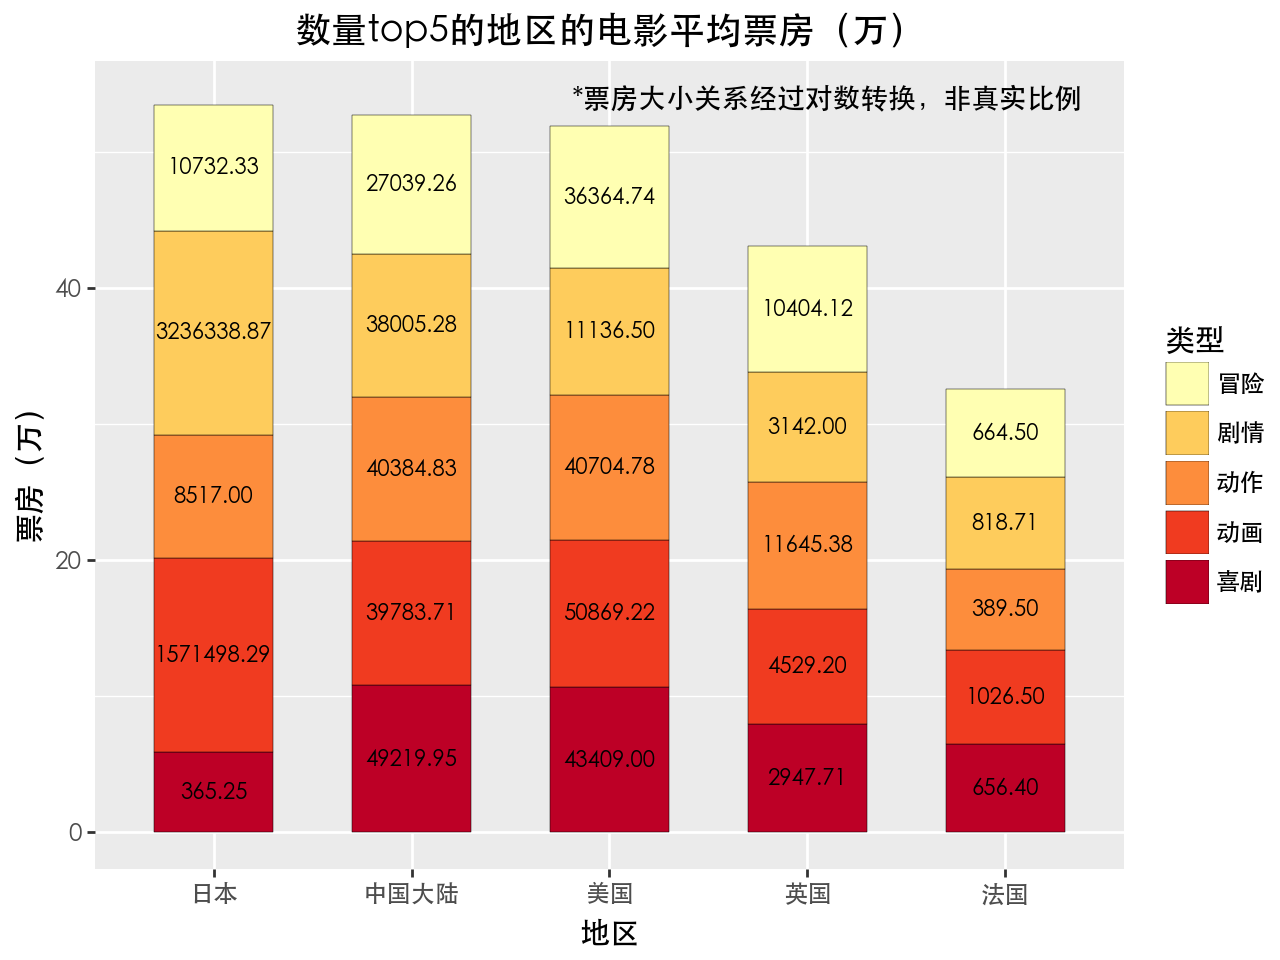

In [28]:
#地区x类型 数量前5的地区前五个类型的平均票房
# 计算每个地区和类型的平均票房
avg_revenue = filtered_data.groupby(['地区','类型']).agg({'票房（万）':'mean'}).reset_index()
avg_revenue['票房（万）_log'] = np.log(avg_revenue['票房（万）'])
# 计算每个国家的票房总和对数
total_revenue = avg_revenue.groupby('地区')['票房（万）'].sum().reset_index()
# 按票房总和排序
total_revenue = total_revenue.sort_values(by='票房（万）', ascending=False)

# 将排序后的国家顺序应用到原始数据
sorted_data = avg_revenue.set_index('地区').loc[total_revenue['地区']].reset_index()

sorted_data['地区'] = pd.Categorical(sorted_data['地区'], categories=total_revenue['地区'].unique(), ordered=True)
t = (
    ggplot(sorted_data, aes(x='地区', y='票房（万）_log', fill='类型'))
    + geom_bar(stat='identity', color='k', position='stack', width=0.6, size=0.1)
    + scale_fill_brewer(palette='YlOrRd')
    + ggtitle("数量top5的地区的电影平均票房（万）")
    + labs(x="地区", y="票房（万）")  # 设置x轴和y轴标题
    + annotate('text', x=4.1, y=54, label='*票房大小关系经过对数转换，非真实比例', size=10, color='black')
    + geom_text(aes(label=sorted_data['票房（万）'].round(2)), position=position_stack(vjust=0.5), size=8, format_string='{:.2f}')
    + theme(text=element_text(family="STHeiti"))
    
)

t

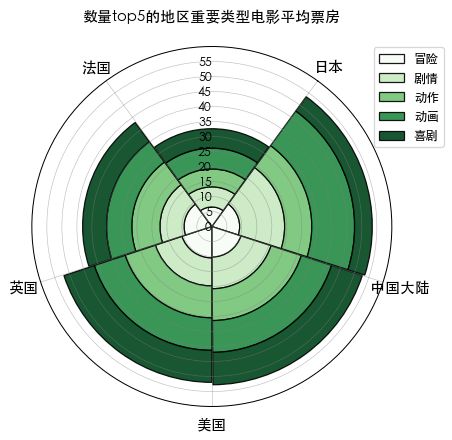

In [29]:
pivot_data_2 = sorted_data.pivot(index='地区', columns='类型', values='票房（万）_log').reset_index()

n_row = pivot_data_2.shape[0]  # 地区数量
n_col = pivot_data_2.shape[1]-1  # 类别数量

# 计算角度
angle = np.arange(0, 2*np.pi, 2*np.pi/n_row)

# 半径数组
radius = pivot_data_2.iloc[:, 1:6].values

cmap = plt.get_cmap('Greens', n_col) #获取颜色主题Reds的Hex颜色编码
color = [colors.rgb2hex(cmap(i)[:5]) for i in range(cmap.N)]
# 绘制堆叠条形图
fig = figure(figsize=(8,5), dpi=90)
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], polar=True)
ax.set_theta_offset(np.pi/2 - np.pi/n_row)
ax.set_theta_direction(-1)
ax.set_rlabel_position(360-180/n_row)
p = [ f"p{i}" for i in range(n_col)]

bottom = radius[:, 0]*0
for i in range(n_col):
    p[i]= plt.bar(angle, radius[:, i], color=color[i], edgecolor='k', width=1.25, bottom=bottom, alpha=0.9, align = 'edge', label=pivot_data_2.columns[i + 1])
    bottom += radius[:, i]  # 更新底部
    
plt.legend(loc='upper left', bbox_to_anchor=(0.95, 1), fontsize=10, borderaxespad=0.)
plt.xticks(angle, labels=pivot_data_2['地区'],fontsize=12) #X轴标签
plt.ylim(0, 60)
plt.yticks(np.arange(0, 60, 5), verticalalignment='center', horizontalalignment='right')#horizontalalignment='right',右侧与90度垂直线对齐
plt.grid(which='major', axis='x', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
plt.grid(which='major', axis='y', linestyle='-', linewidth='0.5', color='gray', alpha=0.5)
plt.title("数量top5的地区重要类型电影平均票房", x=0.5,y = 1.05,fontsize=12)

plt.show()



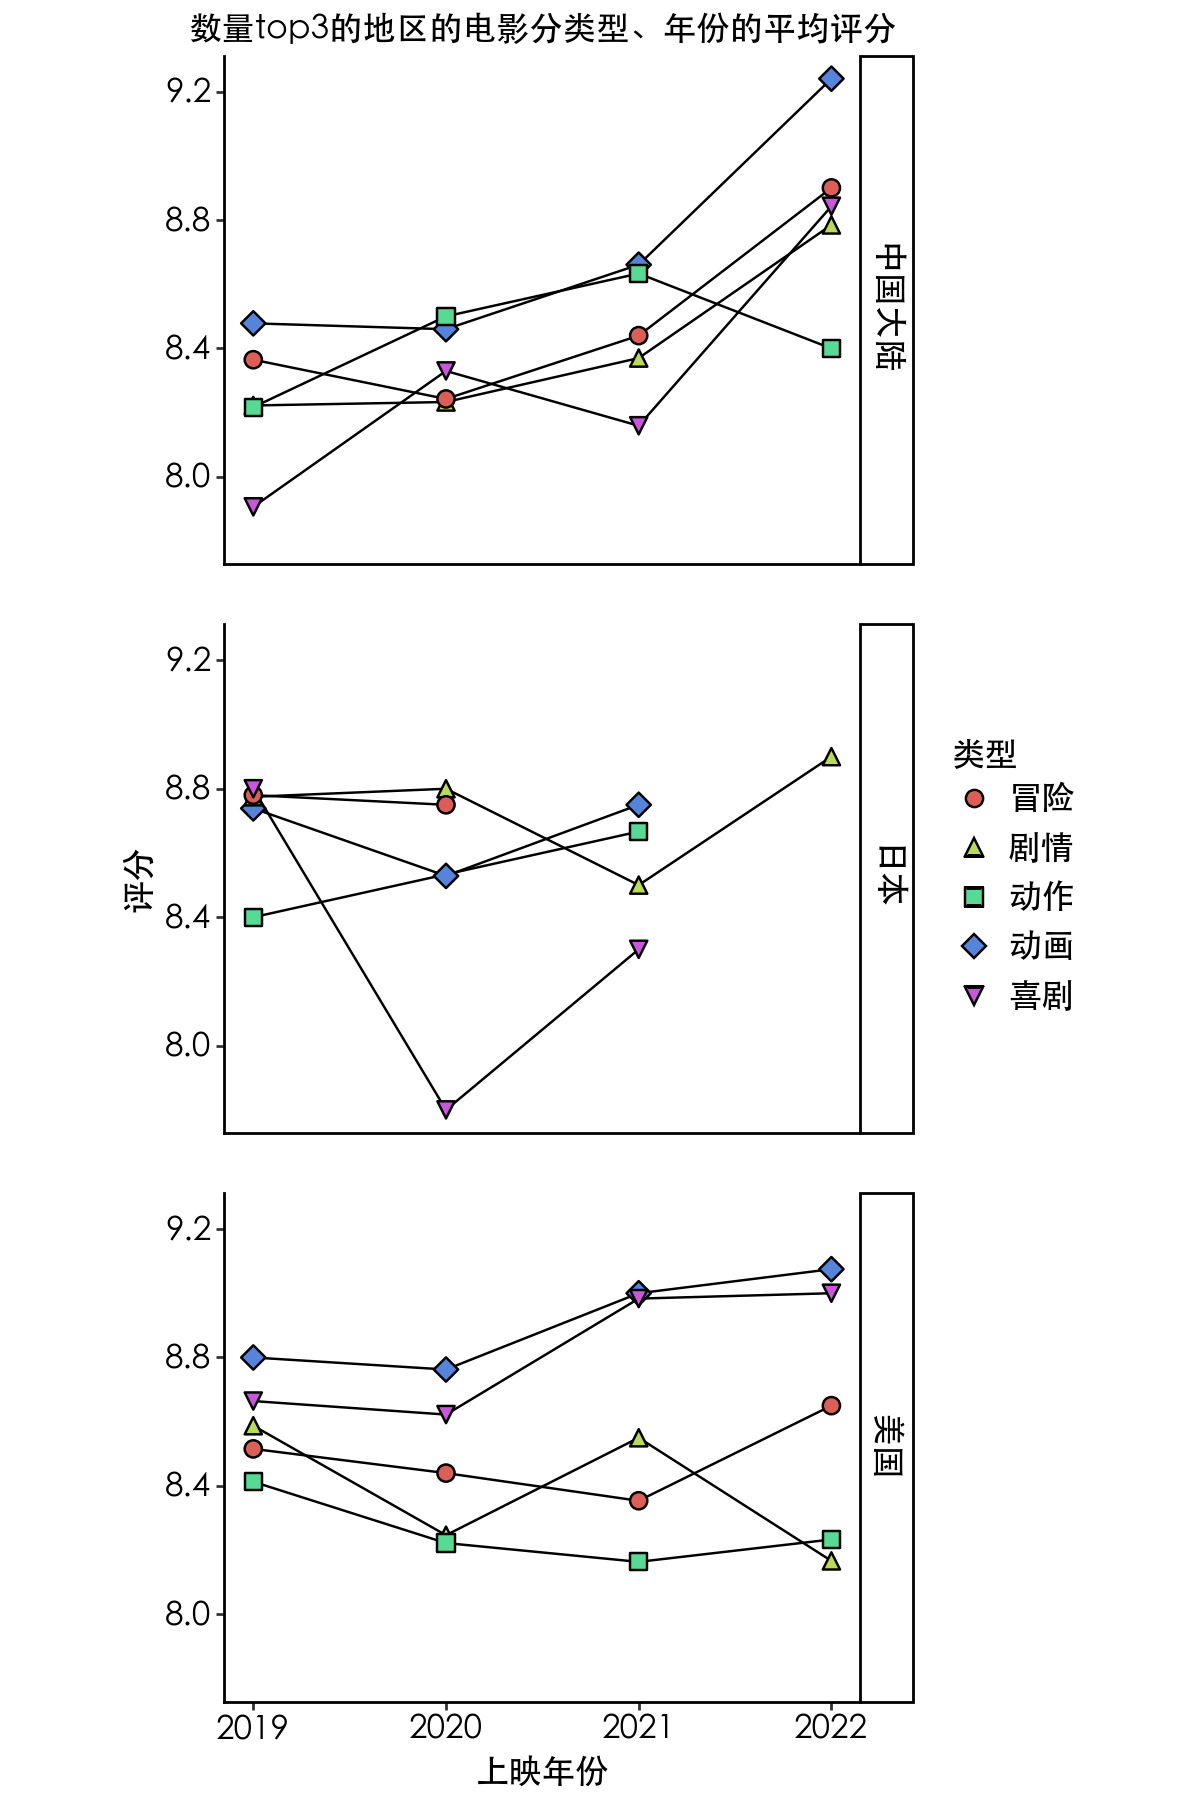

In [30]:
#类型x地区x上映年份
select_region = ['中国大陆','美国','日本']
select_type=['剧情','喜剧','动画','冒险','动作']
data_expanded_type_region['上映年份'] = data_expanded_type_region['上映时间'].dt.year
select_data = data_expanded_type_region[data_expanded_type_region['地区'].isin(select_region) & data_expanded_type_region['类型'].isin(select_type)]

# 计算每个地区、类型、年份的平均评分
avg_scores = select_data.groupby(['地区','类型','上映年份']).agg({'评分': 'mean'}).reset_index()

t = (
    ggplot(avg_scores,aes(x='上映年份',y='评分', fill='类型', shape='类型')) 
    + geom_line()
    + geom_point(size=3,color="black") 
    + ggtitle("数量top3的地区的电影分类型、年份的平均评分")
    + theme_classic()
    + theme(text=element_text(size=12,colour = "black",family="STHeiti"),
        aspect_ratio=0.8,
        dpi=100,
        figure_size=(6,9),
        legend_position='right',  # 将图例放置在顶部
        legend_background=element_rect(fill="none"),
        panel_spacing=0.05
           )
     + facet_grid('地区~.')
)

t

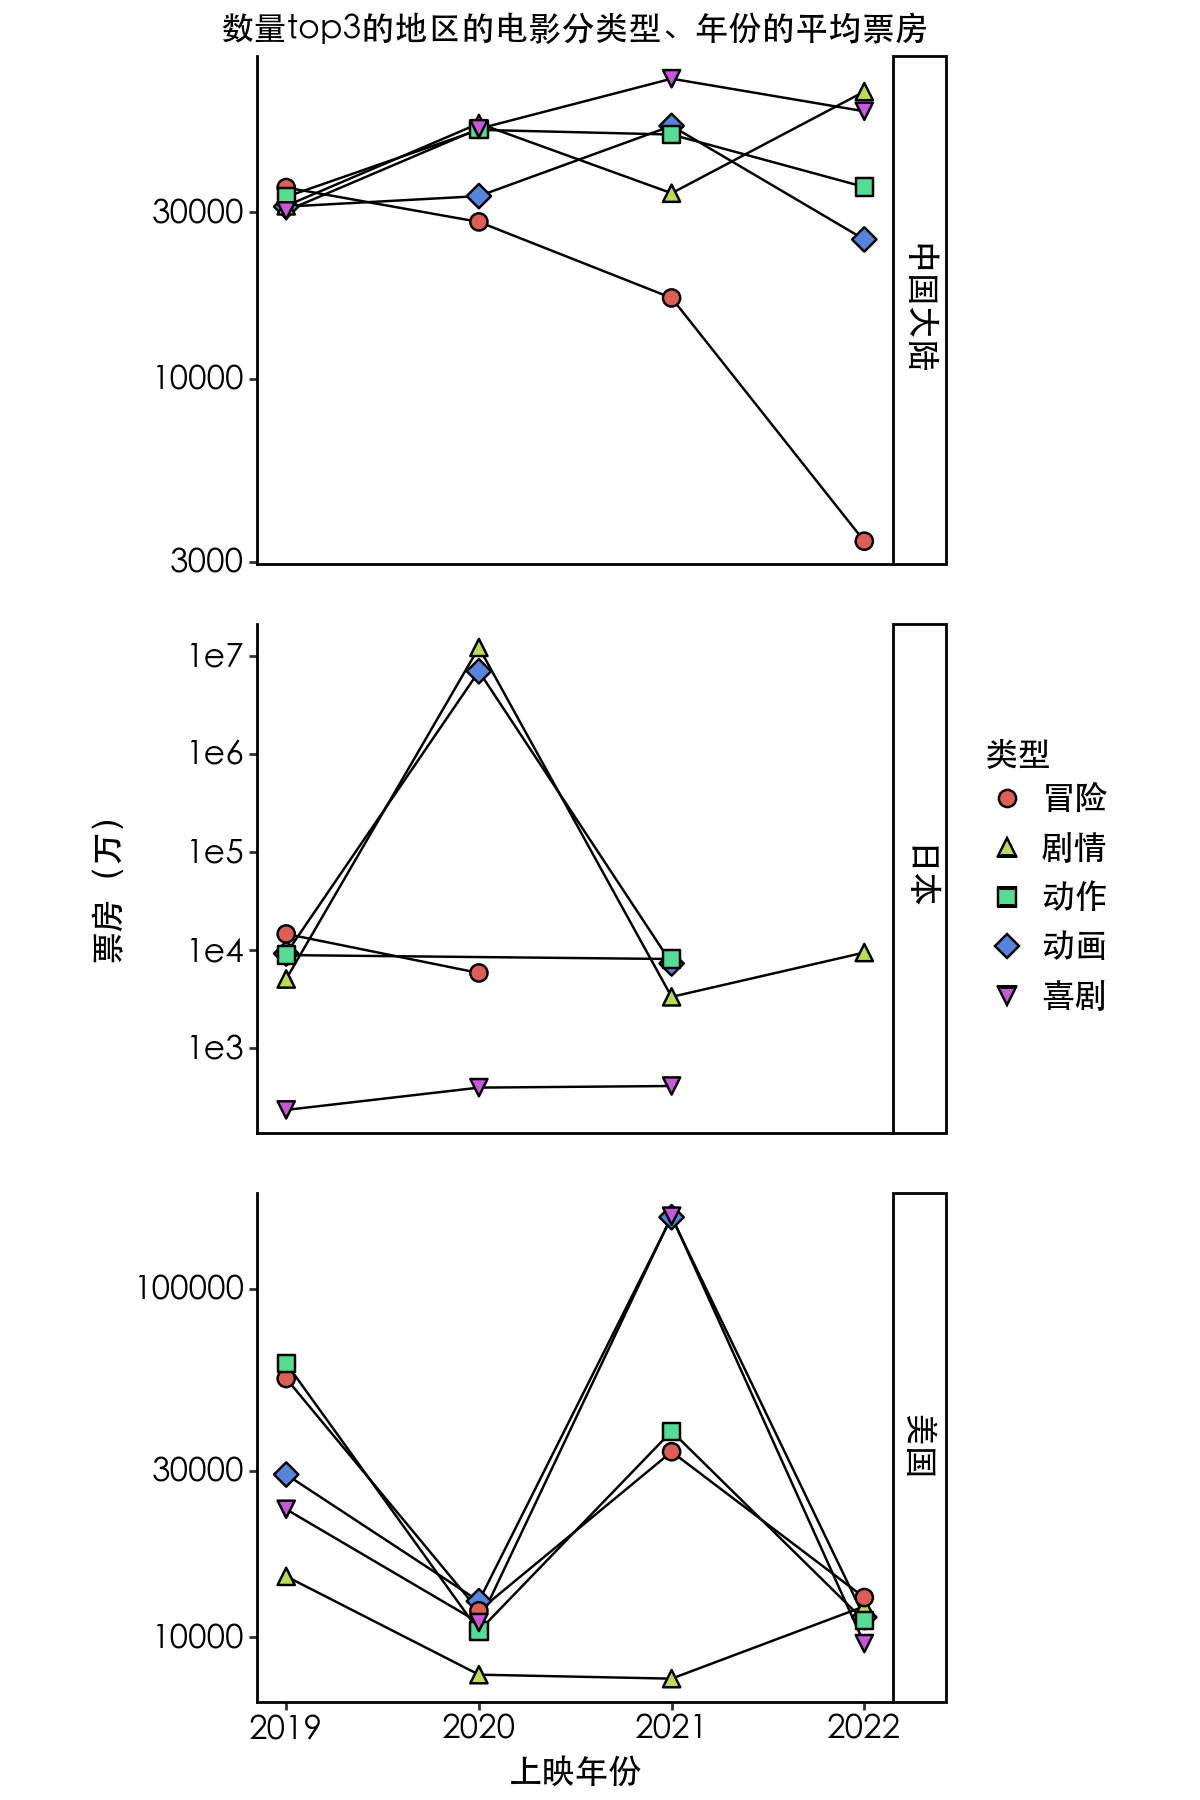

In [33]:
# 计算每个地区、类型、年份的平均评分
avg_revenue = select_data.groupby(['地区','类型','上映年份']).agg({'票房（万）': 'mean'}).reset_index()

t = (
    ggplot(avg_revenue,aes(x='上映年份',y='票房（万）', fill='类型', shape='类型')) 
    + geom_line()
    + geom_point(size=3,color="black") 
    + ggtitle("数量top3的地区的电影分类型、年份的平均票房")
    + scale_y_log10() 
    + theme_classic()
    + theme(text=element_text(size=12,colour = "black",family="STHeiti"),
        aspect_ratio=0.8,
        dpi=100,
        figure_size=(6,9),
        legend_position='right',  # 将图例放置在顶部
        legend_background=element_rect(fill="none"),
        panel_spacing=0.05
           )
    + facet_grid('地区~.', scales='free') 
    

)

t